# <h1> Identify the number of channels open at every time step

## Dataset

Train Data:<br>
1.Time  :-It is  a discrete batches of 50 seconds long 10 kHz samples (500,000 rows per batch). In other words, the data from 0.0001 - 50.0000 is a different batch than 50.0001 - 100.0000<br>
2.Signal :-Electrical signal .<br>
3.Number of channel:- Number of channel open at particular time.There are 0 to 10 channels that can open at any particular time.

Kaggle Competition Link<br>
[University of Liverpool - Ion Switching](https://www.kaggle.com/c/liverpool-ion-switching)

REFERENCED:

1.  [Remove Drift](https://www.kaggle.com/friedchips/clean-removal-of-data-drift)
2.   [Deep-Channel uses deep neural networks to detect single-molecule events from patch-clamp data](https://https://www.nature.com/articles/s42003-019-0729-3)
3.[Remove Sinsosuidal Drift]( http://exnumerus.blogspot.com/2010/04/how-to-fit-sine-wave-example-in-python.html)
4. [Fourier Transform](https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/)
5. [ButterWorth Filter](https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units)


# <h1> Metric</h1>
1.Macro F1
2.Confusion Matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Load requirement 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import lightgbm as lgb
import seaborn as sns
import math
import scipy as sp
import scipy.fftpack
import pywt
from statsmodels.robust import mad
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import joblib
import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
#load data
train_data=pd.read_csv("/content/drive/My Drive/train.csv")
test_data=pd.read_csv("/content/drive/My Drive/test.csv")
print(train_data.shape)
print(test_data.shape)
print(train_data.head())

(5000000, 3)
(2000000, 2)
     time  signal  open_channels
0  0.0001 -2.7600              0
1  0.0002 -2.8557              0
2  0.0003 -2.4074              0
3  0.0004 -3.1404              0
4  0.0005 -3.1525              0


In [ ]:
print("Signal : mean= ",np.mean(train_data['signal'])," median :",np.median(train_data['signal'])," mode : ",stat.mode(train_data['signal'])[0][0])

Signal : mean=  1.3862463138400012  median : 1.124  mode :  -2.5002


Text(0.5, 1.0, 'TIME VS SIGNAL')

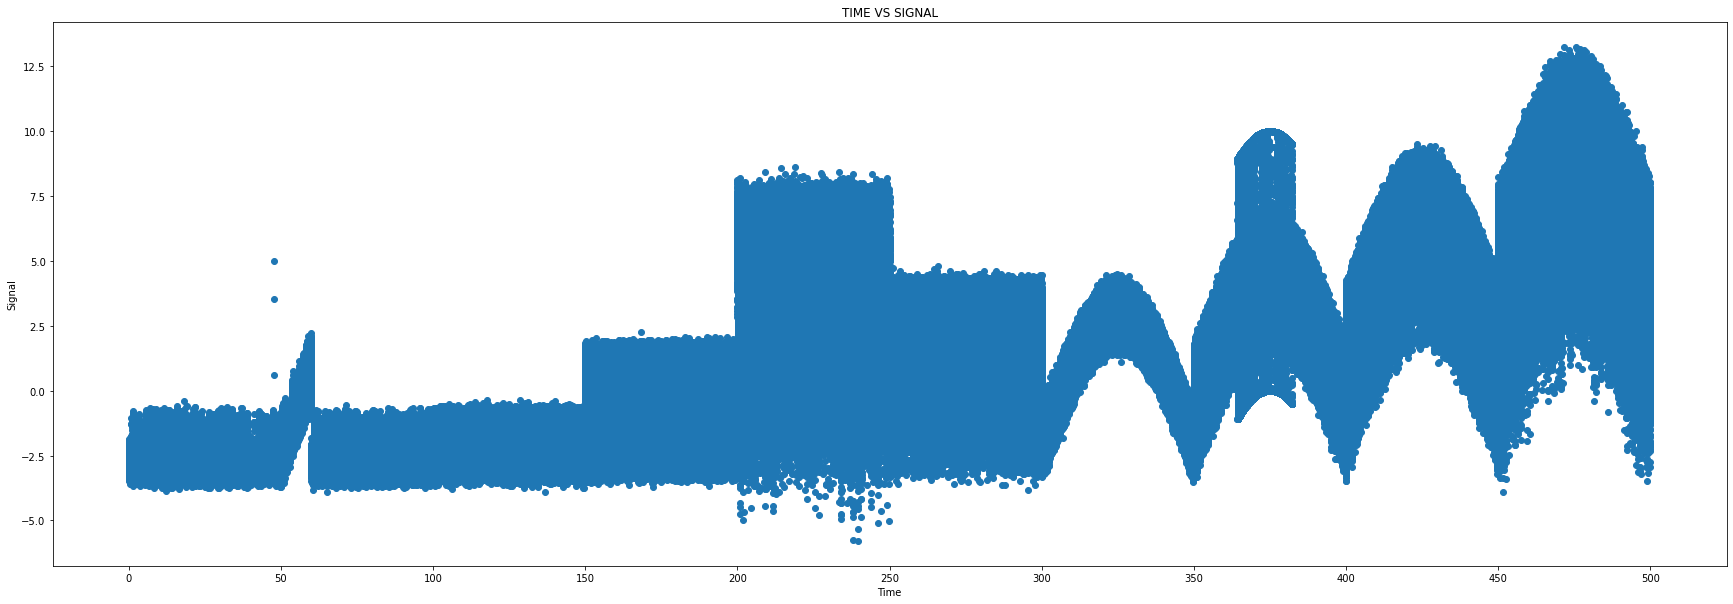

In [ ]:
#plot signal on time vs amplitude of signal
plt.figure(figsize=(30,10))
plt.scatter(train_data['time'],train_data['signal'])

plt.xticks(np.arange(0,550,50))
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("TIME VS SIGNAL")

All the data follow some pattern and it divided in 50 seconds batch .Every batch has max and min point within which all batch oscillating between it's own batch max and min value.Every batch behaviour is different .

In [ ]:
#Find total number of batch in Dataset for every 50 sec of time difference
print("Number of Batch ",train_data.shape[0]/500000)

Number of Batch  10.0


In [ ]:
#Apply rolling mean to smooth the signal
train_data['SMA_3'] = train_data['signal'].rolling(window=500).mean()

Text(0.5, 1.0, 'TIME VS Simple Mean Average')

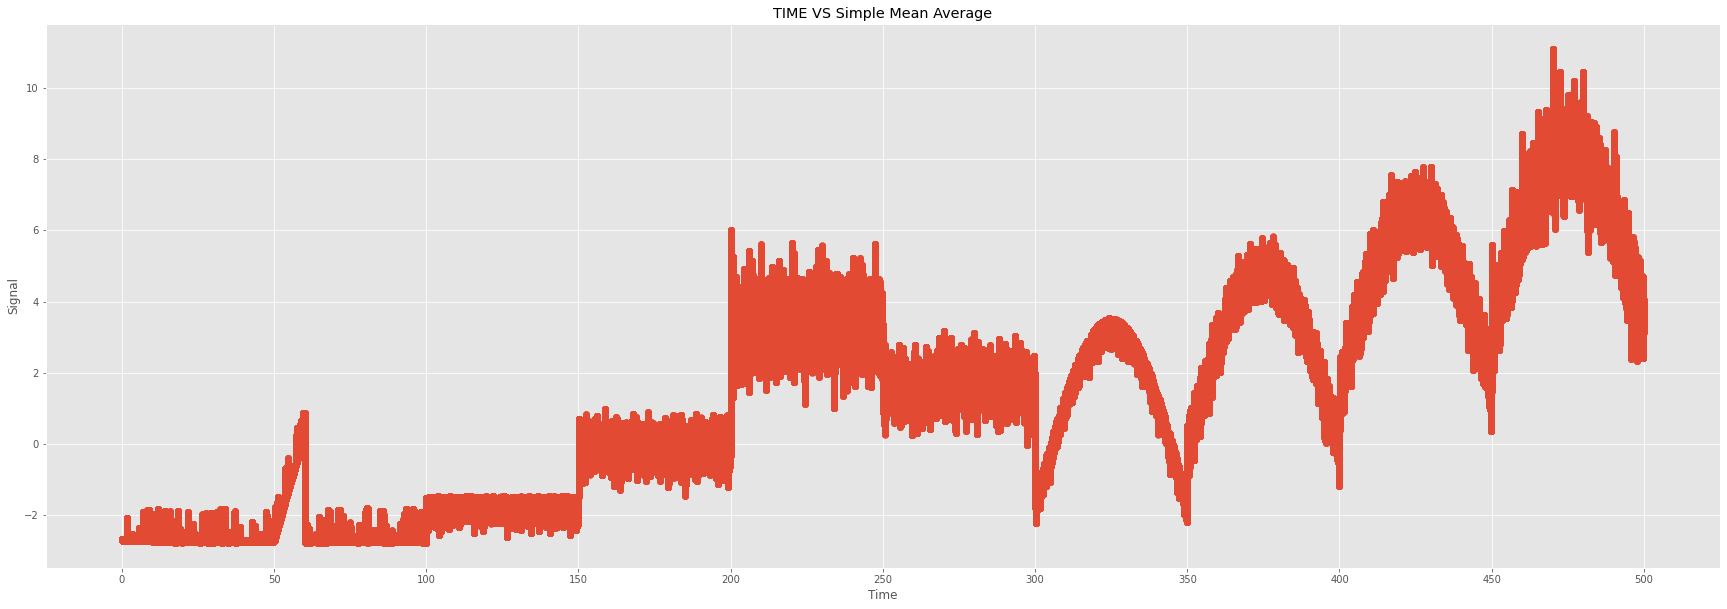

In [ ]:
#Plot the smooth signal 
plt.style.use('ggplot')
plt.figure(figsize=(30,10))
plt.scatter(train_data['time'],train_data['SMA_3'])
plt.xticks(np.arange(0,550,50))
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("TIME VS Simple Mean Average")

There is an added drift in signal which was mention in this paper - [Deep-Channel uses deep neural networks to detect single-molecule events from patch-clamp data](https://https://www.nature.com/articles/s42003-019-0729-3)

<h3> USE Curve fitting Technique to remove drift from the data

# Remove Drift

Some of the batches has added drift.Two type of drift is added first one is linear drift which can be seen in batch 2 and second drift is somewhat like sinosuidal which can seen from batch 7 to batch 10 .

##Remove Linear drift from train data

[ 0.29491589 58.83068736]
[[ 1.90492411e-07 -2.47428951e-06]
 [-2.47428951e-06  5.03898969e-05]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


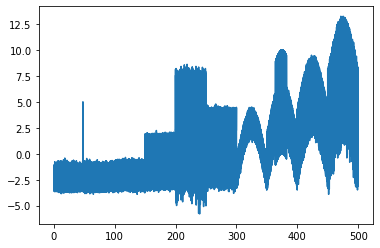

In [ ]:
from scipy.optimize import curve_fit
# Fit the linear curve to linear drift to remove the drift and check by visualize the graph
def linear_model(x, a, b):
  """Mention a function to get curve equation"""
    return a*(x - b)


def linear_drift(x,y):
  """Remove linear drift with linear curve 
     Return : Optimize value for given curve"""
    optimize_Params,poly_cov = curve_fit(linear_model, x, y)
    print(optimize_Params)
    print(poly_cov)
    return optimize_Params

poly_params=linear_drift(train_data['time'][500000:600000],train_data['signal'][500000:600000])
drift=linear_model(train_data['time'][500000:600000],0.3,50.001)
dedrift=train_data['signal'][500000:600000]-drift
train_data['signal'][500000:600000]=dedrift
plt.plot(train_data['time'],train_data['signal'])

##Remove Sinosudial drift 

In [ ]:
#http://exnumerus.blogspot.com/2010/04/how-to-fit-sine-wave-example-in-python.html
#Remove sinosidual drift idea is taken from above link .Finding the best parameter for curve to fit the sinosuidal drift
curve_fit_data=train_data[6*500000:]

def my_sin(x,t):
    f = 0.01
    omega = 2 * np.pi * f
    return 5* np.sin(omega * x + t * np.pi)

def parabolic_drift_fit(data):
    x = data['time']
    y = data['signal']

    frequency = 0.01
    
    rows = np.array([[np.sin(2*np.pi*frequency * t), np.cos(2*np.pi*frequency * t), 1] for t in x])
    b = np.array(y).reshape(len(y), 1)
    A=np.matrix(rows)

    (w,residuals,rank,sing_vals)= np.linalg.lstsq(A, b)
    
    A = np.sqrt(w[0,0]**2 + w[1,0]**2)
    ph = math.atan2(w[1,0], w[0,0])
    d = w[2,0]

    optimize_Params = [A, ph, d]
    print(optimize_Params)
    return optimize_Params


params=[]
for i in [6,7,8,9]:
  params.append(parabolic_drift_fit(train_data[i*500000:i*500000+500000]))
dedrift_data=[]
for i,par in enumerate(params):
  if i in [0,2]:
    dedrift_data.extend(curve_fit_data['signal'][i*500000:i*500000+500000]-my_sin(curve_fit_data['time'][i*500000:i*500000+500000],0))
  else:
    dedrift_data.extend(curve_fit_data['signal'][i*500000:i*500000+500000]-my_sin(curve_fit_data['time'][i*500000:i*500000+500000],3))




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[4.995587084804994, 0.0005740930714585794, -1.8011184167402234]
[5.070119238472453, 3.1382659776739756, -0.15248293248974062]
[4.962839159679722, 0.0005359057886203599, 1.682621252085318]
[5.074016308177288, 3.1360194015343916, 3.2638369771638014]


Text(0.5, 1.0, 'TIME VS SIGNAL')

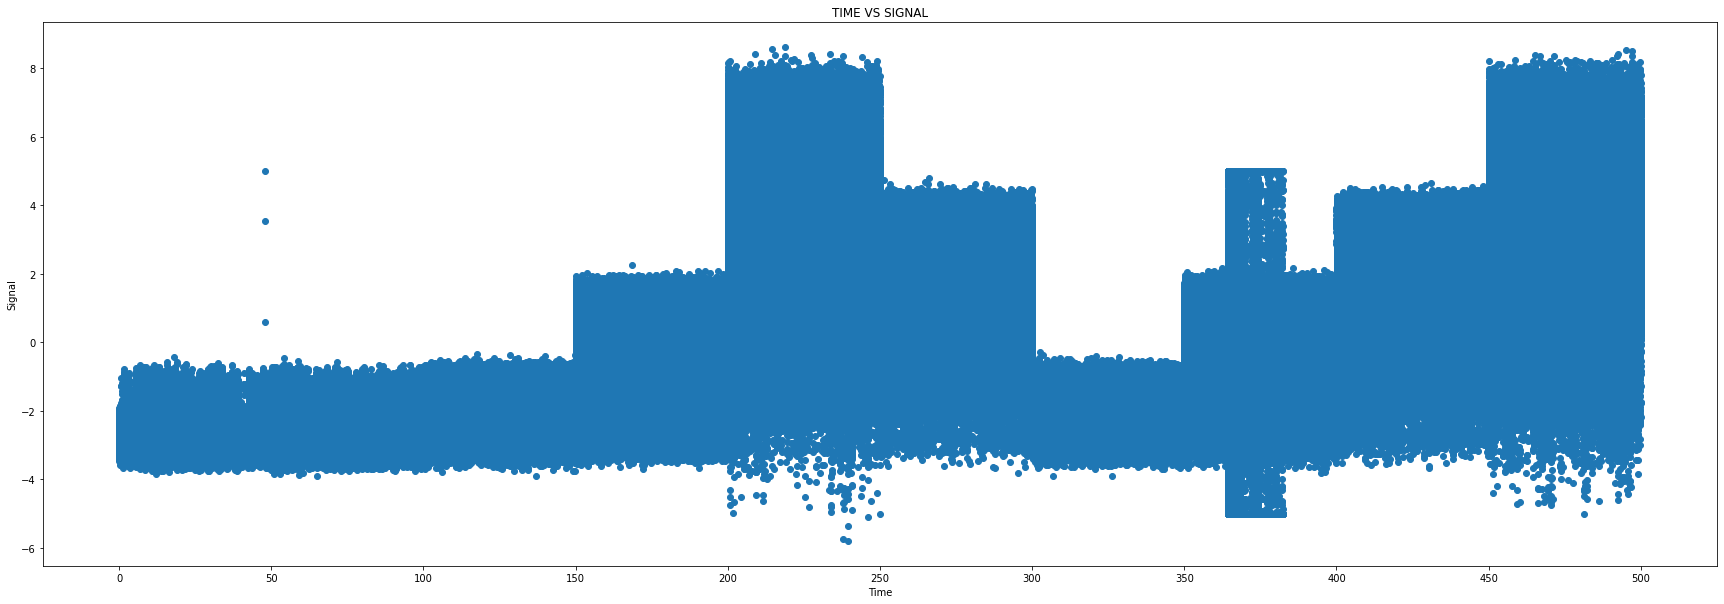

In [ ]:
#Visualize the remove drift signal from train data
train_data['signal'][6*500000:]=dedrift_data
plt.figure(figsize=(30,10))
plt.scatter(train_data['time'],train_data['signal'])

plt.xticks(np.arange(0,550,50))
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("TIME VS SIGNAL")

Drift from the training data signal is remove.

In [ ]:
train_data.to_csv('train_data.csv')
!cp train_data.csv "drive/My Drive/"

## Removing Drift from test data

Text(0.5, 1.0, 'TIME VS SIGNAL')

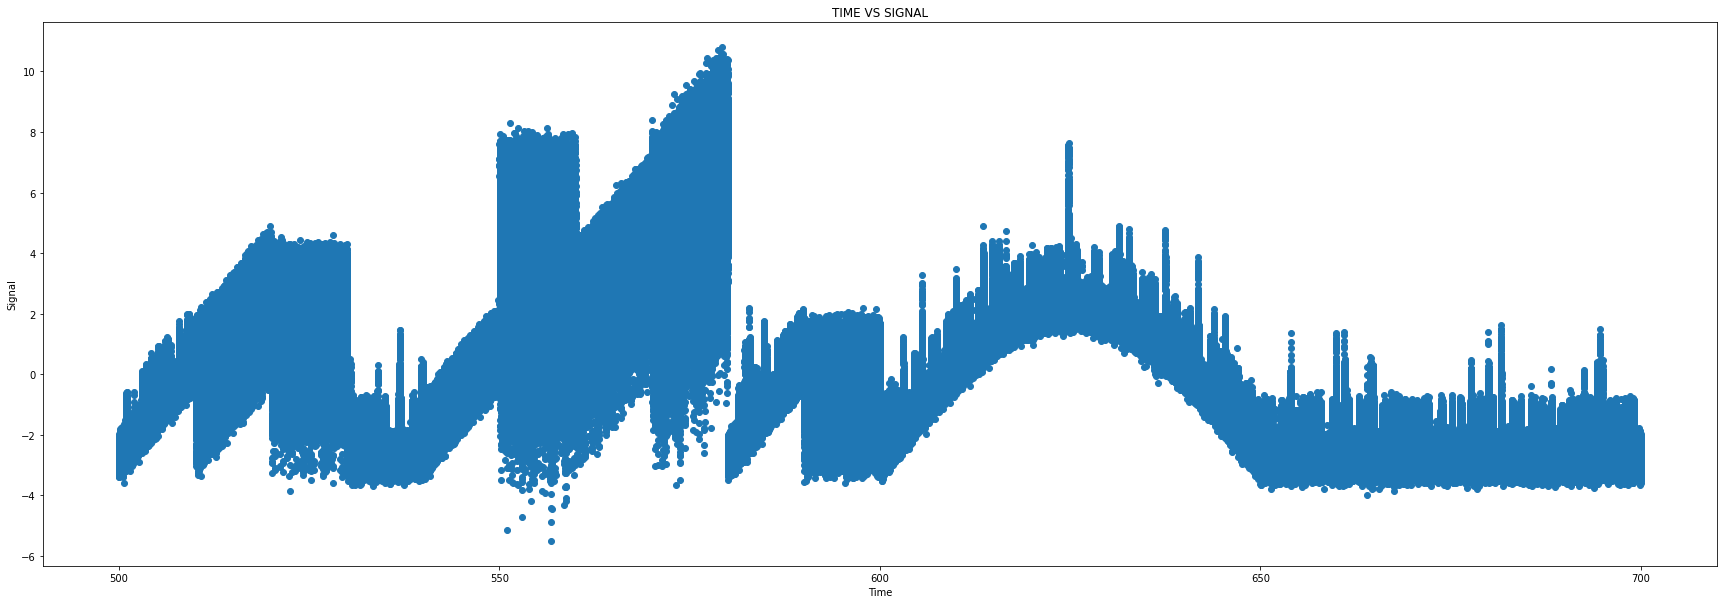

In [ ]:
#Visualize the test signal
plt.figure(figsize=(30,10))

plt.scatter(test_data['time'],test_data['signal'])

plt.xticks(np.arange(500,750,50))
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("TIME VS SIGNAL")

In [ ]:
#Remove drift from batch of test signal
for i in range(10):
  if(i==3 or i== 9):
    continue
  drift_data=test_data[i*100000:i*100000+100000]
  drift=linear_model(drift_data['time'],0.3,drift_data['time'][0:1].values)
  dedrift_data=drift_data['signal']-drift
  test_data['signal'][i*100000:i*100000+100000]=dedrift_data
test_data['signal'][1000000:1500000]=test_data['signal'][1000000:1500000]-my_sin(test_data['time'][1000000:1500000],0)

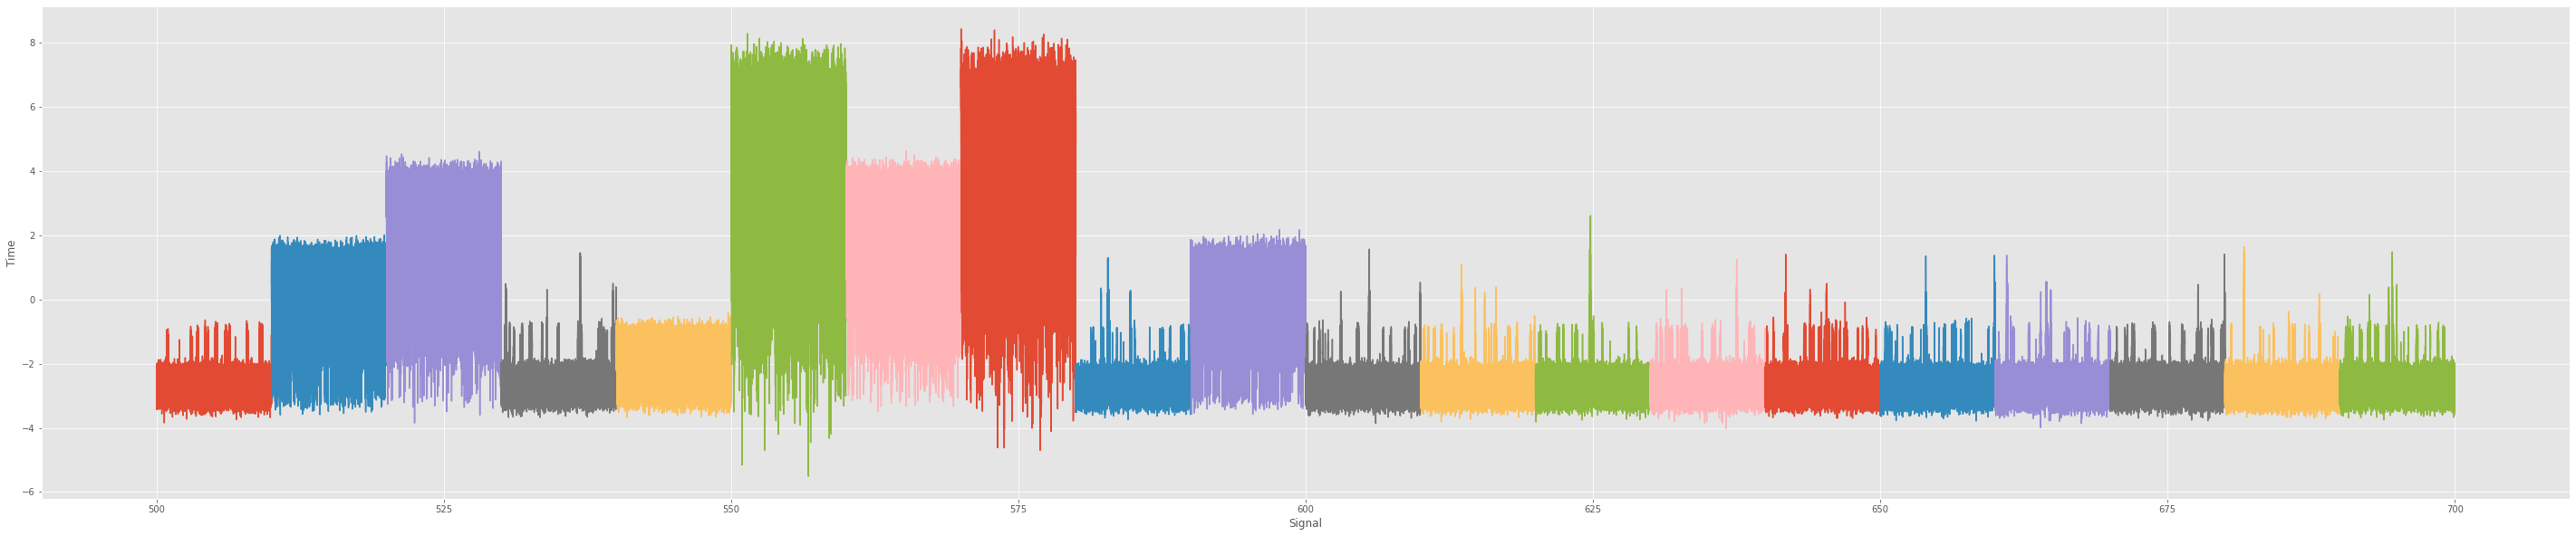

In [ ]:
#Visualize the test signal after removing the drift
plt.figure(figsize=(50,10))
plt.style.use('ggplot')
plt.xlabel("Signal")
plt.ylabel("Time")

for i in range(20):
  plt.plot(test_data['time'][i*100000:i*100000+100000],test_data['signal'][i*100000:i*100000+100000])



In [ ]:
test_data=pd.read_csv('drive/My Drive/test_data.csv')
train_data=pd.read_csv('drive/My Drive/train_data.csv')

# Denoising

The way signal is collected it add noise and drift in signal.We try above tor remove the drift .To remove noise,technique like Fourier Transform,Butterworth filter ,wavelet transform is use.

## Fourier Transform 

With fourier transform ,signal converted into frequency domain.We try to find the power of each frequency component in signal and remove the less power frequency from signal.This way we remove some of low frequency component noise.

In [ ]:
#https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/
#Getting Positive Frequency components of the signal

temp_fft = sp.fftpack.fft(train_data['signal'].values)
temp_psd = np.abs(temp_fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(temp_psd), 1. / 10000)
i = fftfreq > 0

Text(0, 0.5, 'PSD ')

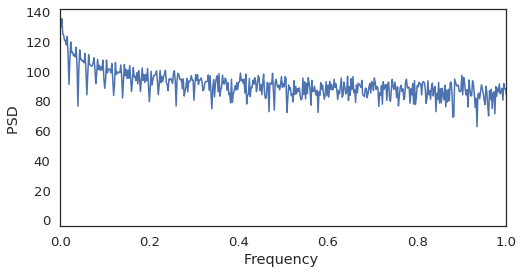

In [ ]:
#By visualizing the power of frequency component to find high frequency components in signal
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], 10*np.log10(temp_psd[i]))
ax.set_xlim(0, 1)
ax.set_xlabel('Frequency ')
ax.set_ylabel('PSD ')


In [ ]:
"""By visualize the above graph we can take below 0.15 frequency components because below that frequency 
   most of frequency components having less power"""
temp_fft_bis = temp_fft.copy()

temp_fft_bis[np.abs(fftfreq) >0.15] = 0


Text(0, 0.5, 'Mean temperature')

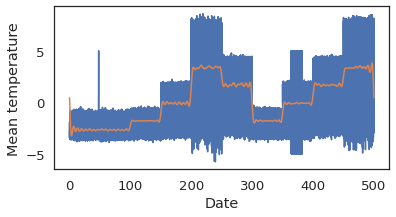

In [ ]:
#Visualize the signal after removing less power frequency component
temp_slow = np.real(sp.fftpack.ifft(temp_fft_bis))
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot(train_data['time'],train_data['signal'])
ax.plot(train_data['time'],temp_slow)
ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature')

In [ ]:
#Adding frequency components as a feature
train_data['Freq_comp']=np.absolute(temp_fft_bis)


In [ ]:
#similiar technique applied on test data
temp_fft = sp.fftpack.fft(test_data['signal'].values)
temp_psd = np.abs(temp_fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(temp_psd), 1. /10000)
i = fftfreq > 0
temp_fft_bis = temp_fft.copy()


Text(0, 0.5, 'Mean temperature')

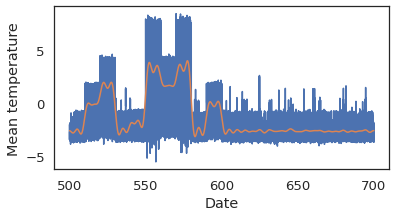

In [ ]:
#Visualize the test data
temp_fft_bis[np.abs(fftfreq) > 0.15] = 0
temp_slow = np.real(sp.fftpack.ifft(temp_fft_bis))
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot(test_data['time'],test_data['signal'])
ax.plot(test_data['time'],temp_slow)
ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature')

In [ ]:
#Adding frequency components as feature
test_data['Freq_comp']=np.abs(temp_fft_bis)


In [ ]:
test_data.to_csv("test_data.csv")
!cp test_data.csv "drive/My Drive/"

## Butterworth Low Pass Filter

Butterworth filter low pass filter is used to pass only the low frequency components than the threshold frequency.This technique is similiar that we apply above but this is advance way to do that.

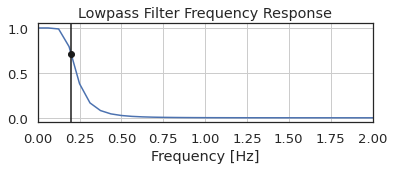

In [ ]:
#https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
#This idea is taken from above link .This help to find the best threshold frequency compoent for butterworth filter
#By visualize the graph to find the best threshold frequency 
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low',analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order =4
n_samples = 50000
sample_duration = 50
fs = n_samples * (1 / sample_duration) # sample rate, Hz
cutoff =0.2 # desired cutoff frequency of the filter, Hz
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 2)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()



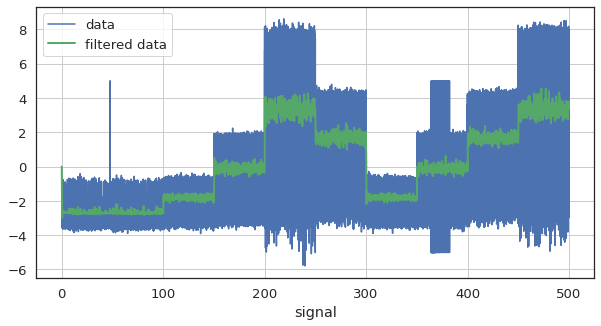

In [ ]:
#Apply butterworth filter on the signal
t=train_data['time']
y = butter_lowpass_filter(train_data['signal'], cutoff, fs, order)

plt.figure(figsize=(10,5))
plt.plot(t, train_data['signal'], 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('signal')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

In [ ]:
#Use butterworth filter signal as features
train_data['Butter_fil']=y

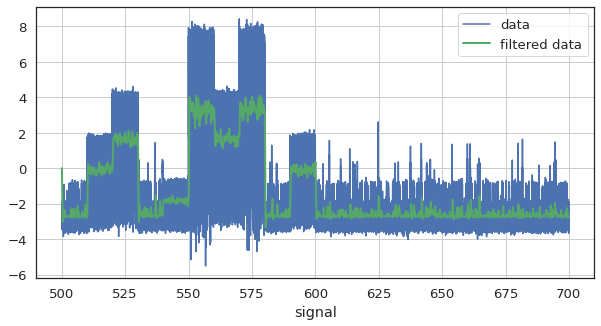

In [ ]:
#Similiar thing is done on test data.
t=test_data['time']
y = butter_lowpass_filter(test_data['signal'], cutoff, fs, order)

plt.figure(figsize=(10,5))
plt.plot(t, test_data['signal'], 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('signal')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

In [ ]:
#Adding butterworth filtered signal as feature
test_data['Butter_fil']=y

In [ ]:
train_data.to_csv('train_data.csv')
!cp train_data.csv 'drive/My Drive/'

## Wavelet denosing

Wavelet is advance to analysis and remove noise from the signal.It use different wavelet contain some set of frequency and convolute with signal to get information of the frequency in the signal

In [ ]:
#https://stackoverflow.com/questions/56789030/why-is-wavelet-denoising-producing-identical-results-regardless-of-threshold-lev
#From above link idea is taken to find the best parameter for wavelet denoising
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(data,wavelet,modes):
  """Remove noise from the signal and returned denoised signal"""
  w = pywt.Wavelet(wavelet)

  coeff = pywt.wavedec(data, wavelet, mode=modes )
  level=pywt.dwt_max_level(train_data.shape[0], w.dec_len)
  
  
  # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
  
  sigma = (1/0.6745) * maddest( coeff[-level] )
  uthresh=sigma * np.sqrt( 2*np.log( train_data.shape[0]) )

  coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )

  # Reconstruct the signal using the thresholded coefficients
  y=pywt.waverec( coeff, wavelet, mode=modes )
  return y

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


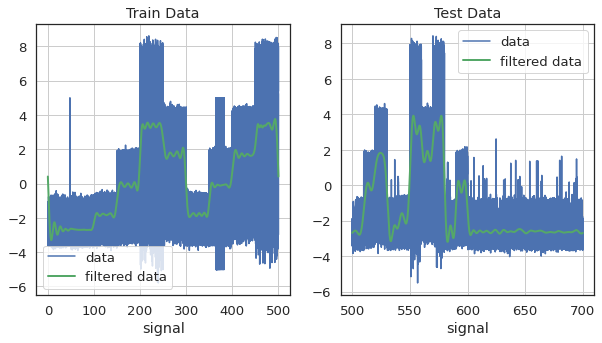

In [ ]:
#Remove noise from the training and testing signal and visualize after removing the signal

wavelet_denoising_train= wavelet_denoising(train_data['signal'],'db20','per')
wavelet_denoising_test= wavelet_denoising(test_data['signal'],'db20','per')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_data['time'], train_data['signal'], 'b-', label='data')
plt.plot(train_data['time'], wavelet_denoising_train, 'g-', linewidth=2, label='filtered data')
plt.xlabel('signal')
plt.title("Train Data")
plt.grid()
plt.legend()

plt.subplot(1,2,2)

plt.plot(test_data['time'], test_data['signal'], 'b-', label='data')
plt.plot(test_data['time'], wavelet_denoising_test, 'g-', linewidth=2, label='filtered data')
plt.xlabel('signal')
plt.grid()
plt.legend()
plt.title("Test Data")

plt.subplots_adjust(hspace=0.35)
plt.show()

In [ ]:
#Adding the wavelet denoisined signal as feature
train_data['Wavelet_denoising']=wavelet_denoising_train
test_data['Wavelet_denoising']=wavelet_denoising_test

# <h1> Exploratory data analysis

Analysis the signal try to find some pattern that will help to make some feature for out machine learning model.Try to analysis different channel,find some pattern that will help to differentiate the channel with each other.Analysis the denoised signal,Is it helpful to differentiate the channel with each other.

In [ ]:
#Analysis the signal by some basic statistic term
train_data.describe()

,time,signal,open_channels,Freq_comp,Butter_fil,Wavelet_denoising
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,2.500001e+02,8.301247e-02,2.726043e+00,8.301247e-02,8.156094e-02,8.351345e-02
std,1.443376e+02,2.487342e+00,2.665051e+00,2.197976e+00,2.213249e+00,2.200741e+00
min,1.000000e-04,-5.796500e+00,0.000000e+00,-3.217957e+00,-2.985993e+00,-3.222969e+00
25%,1.250001e+02,-2.099600e+00,1.000000e+00,-1.838603e+00,-1.883275e+00,-1.836280e+00
50%,2.500000e+02,-3.163000e-01,2.000000e+00,-9.913945e-02,-1.059916e-01,-9.439029e-02
75%,3.750000e+02,1.976200e+00,4.000000e+00,1.734131e+00,1.823928e+00,1.740778e+00
max,5.000000e+02,8.613100e+00,1.000000e+01,3.902900e+00,4.484890e+00,4.110394e+00


In [ ]:
#Total number of channel present is signal
print("set of Unique Channels open at a time = " ,sorted(train_data['open_channels'].unique()))

set of Unique Channels open at a time =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


0 mean closed and other a number of channel open at particular time

In [ ]:
#Group signal channel wise
g=train_data.groupby(['open_channels']).aggregate('mean')

Text(0.5, 1.0, 'Channel wise Distribution ')

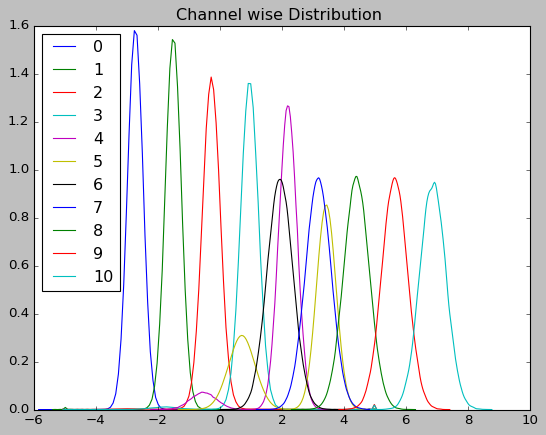

In [ ]:
#Visualize signal
for channel in range(11):
  sns.kdeplot(train_data[train_data['open_channels']==channel]['signal'],label=str(channel))
plt.title("Channel wise Distribution ")

Distribution of channel 0,1,2,3 seperate easily but channels 4 to 10 has overlapping distribution.  

Text(0.5, 1.0, 'Channel wise Distribution frequecy component ')

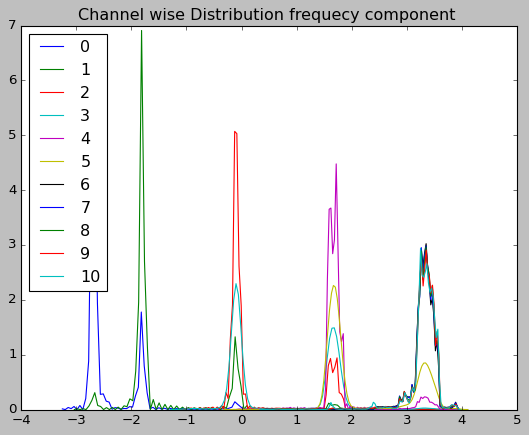

In [ ]:
#Visualize signal distribution by group the signal with channel to find the behaviour of the signal with frequency compoent
for channel in range(11):
  sns.kdeplot(train_data[train_data['open_channels']==channel]['Freq_comp'],label=str(channel))
plt.title("Channel wise Distribution frequecy component ")

All the frequency components are present in every channels no one has single frequency to differentiate.

Text(0.5, 1.0, 'Channel wise Distribution of Butterworth low pass filter')

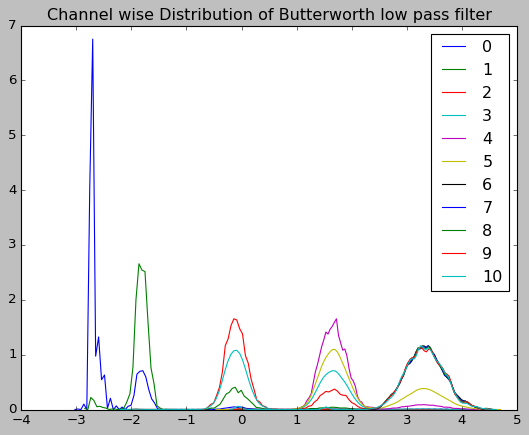

In [ ]:
#Visualize the signal distribution channel wise to find the behaviour of butterworth filter signal
for channel in range(11):
  sns.kdeplot(train_data[train_data['open_channels']==channel]['Butter_fil'],label=str(channel))
plt.title("Channel wise Distribution of Butterworth low pass filter")

Channel 0 and 1 are slightly differentiable but most of the channels has overlapping nature

Text(0.5, 1.0, 'Channel wise Distribution of Wavelet Denosing')

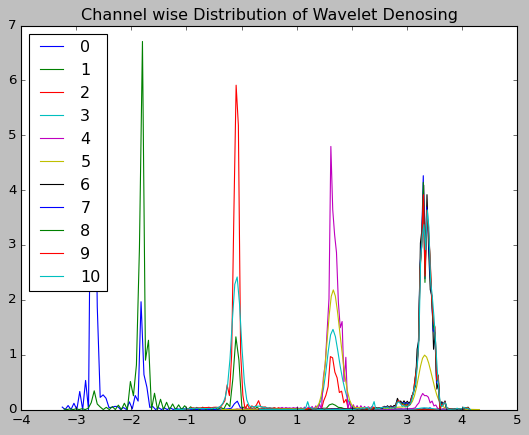

In [ ]:
#Visualize the signal distribution channel wise to find the behaviour of Wavelt denoised signal
for channel in range(11):
  sns.kdeplot(train_data[train_data['open_channels']==channel]['Wavelet_denoising'],label=str(channel))
plt.title("Channel wise Distribution of Wavelet Denosing")

wavelet denoising is not good to seperate channels by their frequency

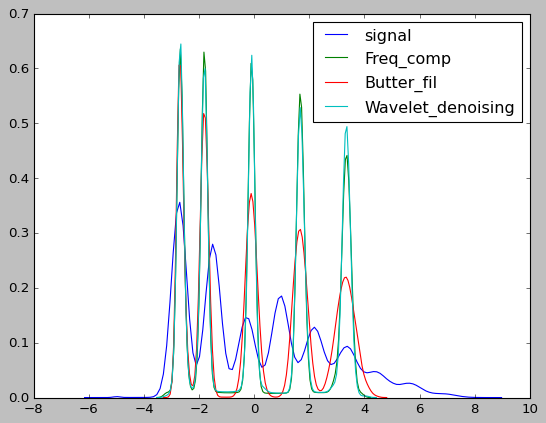

In [ ]:
#Visualize the signal distribution with all the denoised technique to find behaviour of denoised signal
sns.kdeplot(train_data['signal'])
sns.kdeplot(train_data['Freq_comp'])
sns.kdeplot(train_data['Butter_fil'])
sns.kdeplot(train_data['Wavelet_denoising'])

Fourier transform and Butterworth filter has similiar frequency pattern than the wavelet.Both the fourier transfrom and butterworth filter show similiar pattern that is acceptable because after removing  noise from signal there distribution must be same but  wavelet denosing does't follow the distribution.This is not good .

Text(0.5, 1.0, 'Signal vs Open Channels')

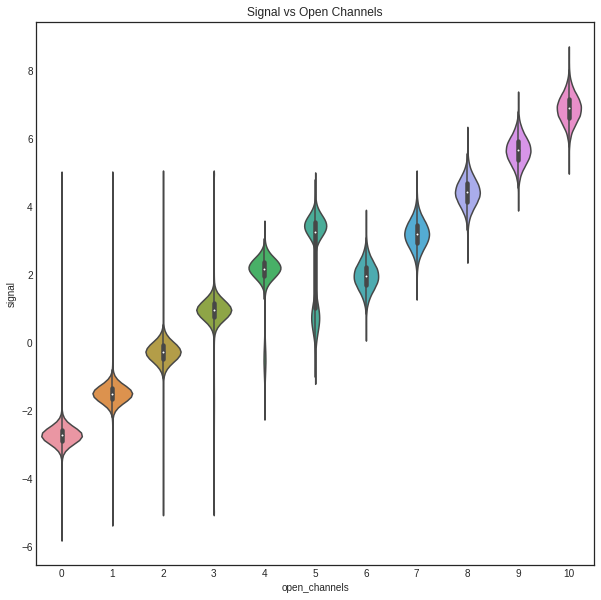

In [ ]:
"""Visualize the violin plot to find the difference between the open channel distribution """
plt.style.use('seaborn-white')
plt.figure(figsize=(10,10))
sns.violinplot(train_data['open_channels'],train_data['signal'])
plt.title("Signal vs Open Channels")

Signal distribution is good to seperate the different channel.This show that the signal is helpful to differentiate the channels.This may be a useful feature for our model.

Text(0.5, 1.0, 'ButterWorth_Filter vs openChannels')

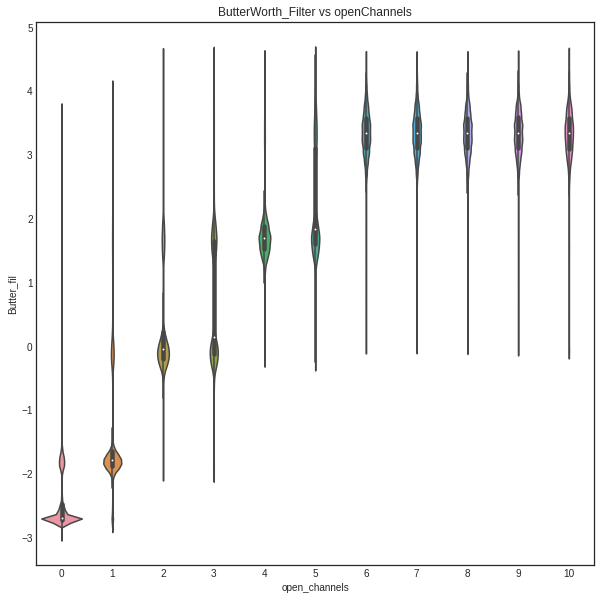

In [ ]:
"""Try same analysis on the butterworth filtered signal """
plt.figure(figsize=(10,10))
sns.violinplot(train_data['open_channels'],train_data['Butter_fil'])
plt.title("ButterWorth_Filter vs openChannels")

Butterworth filter is good to seperate the Channels from 0 to 5 but from channels 6 to 10 they are fully overlapping.Butterworth filter show much variances in each channels that is not good as a feature.But still it helpful to differentiate between the channels 0 to 5.

Text(0.5, 1.0, 'Wavelet_denoising vs openchannels')

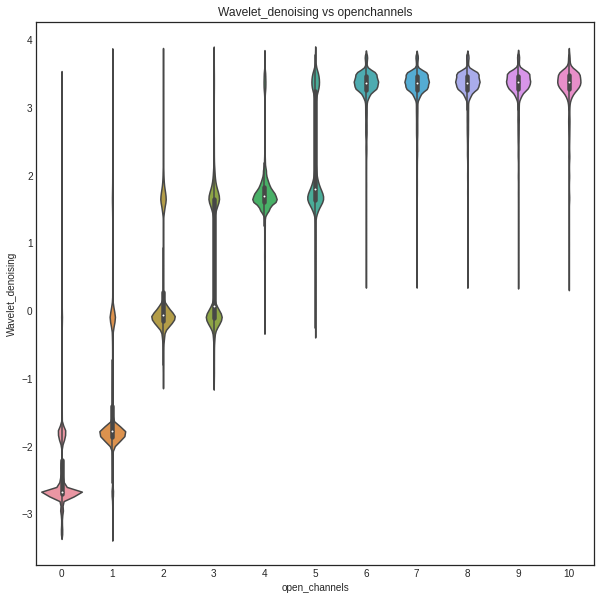

In [ ]:
"""Similiar analysis on wavelet denoised signal"""
plt.figure(figsize=(10,10))
sns.violinplot(train_data['open_channels'],train_data['Wavelet_denoising'])
plt.title("Wavelet_denoising vs openchannels")

This is also showing same behaviour.So our conclusion is that  it useful to <br>differentied 0to4 number of channels.But it not  working well with the <br>other  channels.We try with these as a feature.

##Conclusion:



1.   Amplitude of signal is good to seperate the different channel .
2. Denoised signal is good to seperate the channels from 0 to 5 but not able to seperate from channel 6 to 10.

3. Wavelet denoised signal is not following the same nature of the other denoised signal.This can be more informative or less.By analysis the wavelet denoised signal work similiar as the other denoised signal is working.

4. Most of the Frequency components are overlapping for different channels also.This meant that not a particular frequency component is open the different channels.This is abvious that if 5 channels are open then the 5 different frequency may be there to open 5 different channels.





# Feature Engineering

As we see earlier that the amplitude of the signal are good to seperating the <br>number of open channels.We will look some other features that have some <br>power component of the frequency components it have.

# Maximum Powered Frequency

With maximum powered frequency in signal we will seperated the maximum powered frequency in range.This will help to find the phase of signal and power.

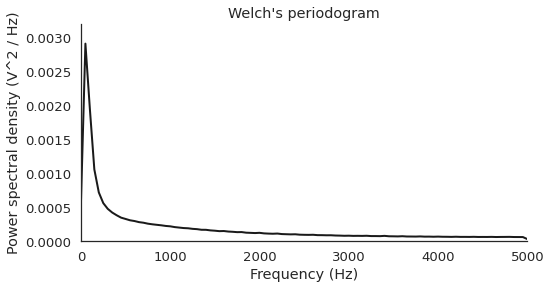

In [ ]:
from scipy import signal
"""Find the range of frequency that contain maximum frequency components"""
# Define window length (4 seconds)
sf=10000
win = 1/50*10000
freqs, psd = signal.welch(train_data['signal'], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

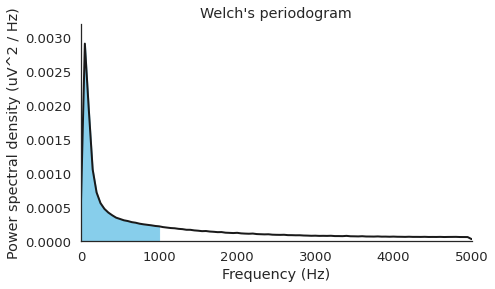

In [ ]:
"""Visualize the range of frequency is selected"""
low, high = 0, 1000

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 5000])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [ ]:
from scipy.integrate import simps
 """Understand the power of signal with the range of frequency is used above"""
# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 0.619 uV^2


In [ ]:
"""Relative Power show that how much power is carried by the range of frequency from the total power of signal"""
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

Relative delta power: 0.609


<h3> Maximum power of signal is in between 0 to 1000Hz frequency range.<br>
Let's get the power and phase as features.

In [ ]:
def frequency_features(data):
  """
  Getting the phase,frequency components,power as features
  """
  temp_fft = sp.fftpack.fft(data.values)
  temp_psd = np.abs(temp_fft) ** 2
  fftfreq = sp.fftpack.fftfreq(len(temp_psd), 1. / 10000)
  i = fftfreq > 0
  temp_fft_bis = temp_fft.copy()

  temp_fft_bis[np.abs(fftfreq) >1] = 0 # Getting  frequency components below 1khz 
  temp_slow = np.real(sp.fftpack.ifft(temp_fft_bis))
  phase =np.angle(temp_fft_bis)
  psd=np.abs(temp_fft)*2
  return temp_slow,phase,psd
train_freq_comp,train_phase,train_psd=frequency_features(train_data['signal'])
test_freq_comp,test_phase,test_psd=frequency_features(test_data['signal'])
train_data['Max_freq_comp'],train_data['Freq_phase'],train_data['Freq_power']=train_freq_comp,train_phase,train_psd
test_data['Max_freq_comp'],test_data['Freq_phase'],test_data['Freq_power']=test_freq_comp,test_phase,test_psd

In [ ]:
test_data.to_csv('test_data.csv',index=False)
!cp test_data.csv "drive/My Drive"

<h3>Time Feaquency Spectrum Power Analysis

Previously we only analysis the frequency domain of the signal not the timefrequency domain of the signal.This will help to find how the frequency component is changing over time.

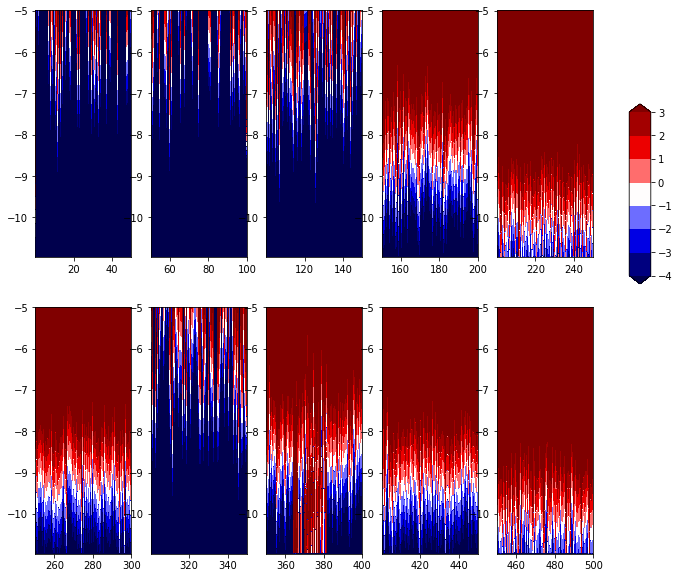

In [ ]:
"""TimeFrequency spectrum is way to visualize the signal power changes over time
   This analysis is done on batch wise of signal """
dt = train_data.time[1] - train_data.time[0]
coeff=np.zeros(train_data.shape[0])
waveletname='gaus1'
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period (years)'
xlabel = 'Time'
cmap = plt.cm.seismic
scales = np.arange(1, 64)
fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(10,10))
for i , axis in enumerate(axes):
  for e , ax in enumerate(axis):
    batch_min=500000*(e+i*5)
    batch_max=batch_min+500000
    signal =train_data.Wavelet_denoising[batch_min:batch_max]
    time=train_data.time[batch_min:batch_max]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)

    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)

    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)

cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
fig.colorbar(im, cax=cbar_ax, orientation="vertical")
plt.show()

This graph shows the timefrequency power is same graph.Redness and Blueness  of graph show how the frequency components power is changes with time .Redness show the frequency components has high power and blue show low power.This graph is done to find periodicty of the signal .But there is no perodicity is signal

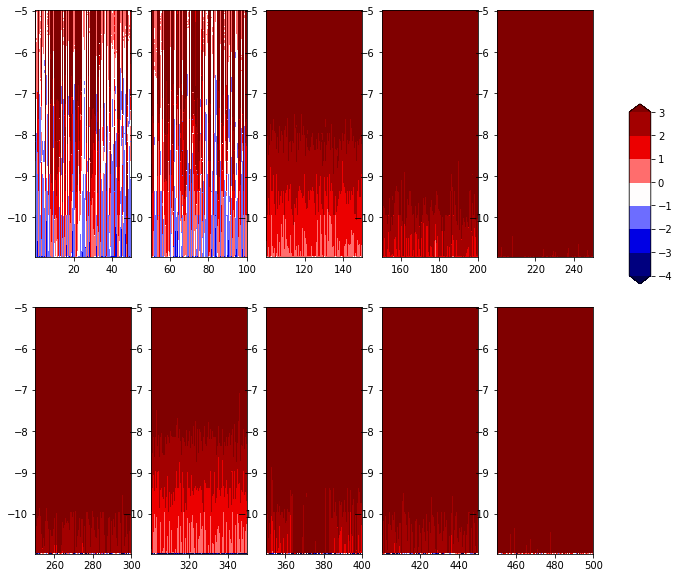

In [ ]:
""""Try the previous analysis on training data"""
dt = train_data.time[1] - train_data.time[0]
coeff=np.zeros(train_data.shape[0])
waveletname='gaus1'
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period (years)'
xlabel = 'Time'
cmap = plt.cm.seismic
scales = np.arange(1, 64)
fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(10,10))
for i , axis in enumerate(axes):
  for e , ax in enumerate(axis):
    batch_min=500000*(e+i*5)
    batch_max=batch_min+500000
    signal =train_data.signal[batch_min:batch_max]
    time=train_data.time[batch_min:batch_max]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)

    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)

    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)

cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
fig.colorbar(im, cax=cbar_ax, orientation="vertical")
plt.show()



---



---


There is difference all the batch but there is no perodicity.This may  help to predict the number of open channels let use as a features.

In [ ]:
"""Getting Features like power ,total power of signal ,average power,max power,min power,maxmin powerdifference
   batch wise of the signal."""
def time_features_spectrum_features(data,Time):
  coeff=np.zeros([len(data),7])
  waveletname='gaus1'
  scales = np.arange(1, 64)
  dt = 0.0001
  r=int(len(data)/500000)
  coeff[:,0]=Time
  for i in range(r):
      batch_min=500000*(i)
      batch_max=batch_min+500000
      signal =data[batch_min:batch_max]
      time=Time[batch_min:batch_max]
      [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
      power = (abs(coefficients)) ** 2
      power=np.log2(power)
      total_power=np.sum(power.T,axis=1)
      avg_power=total_power/63
      max_power= np.max(power.T,axis=1)
      min_power=np.min(power.T,axis=1)
      diff_minmax_power=max_power-min_power
      avg_diffminmax_power=diff_minmax_power/2
      coeff[batch_min:batch_max,1]+=total_power
      coeff[batch_min:batch_max,2]+=avg_power
      coeff[batch_min:batch_max,3]+=max_power
      coeff[batch_min:batch_max,4]+=min_power
      coeff[batch_min:batch_max,5]+=diff_minmax_power
      coeff[batch_min:batch_max,6]+=avg_diffminmax_power
  
  return coeff

  

train_powerfeat_wavelet=time_features_spectrum_features(train_data['Wavelet_denoising'],train_data['time'])
train_powerfeat_signal=time_features_spectrum_features(train_data['signal'],train_data['time'])
test_powerfeat_wavelet=time_features_spectrum_features(test_data['Wavelet_denoising'],test_data['time'])
test_powerfeat_signal=time_features_spectrum_features(test_data['signal'],test_data['time'])
wavlet_power_columns_name=['time','walet_tpower','walet_avgpower','wavlet_maxpower','wavlet_minpower','wavlet_difpower','walet_avgdifpower']
sig_power_columns_name=['time','sig_tpower','sig_avgpower','sig_maxpower','sig_minpower','sig_difpower','sig_avgdifpower']
train_powerfeat_wavelet=pd.DataFrame(train_powerfeat_wavelet,columns=wavlet_power_columns_name)
train_powerfeat_sig=pd.DataFrame(train_powerfeat_signal,columns=sig_power_columns_name)
test_powerfeat_wavelet=pd.DataFrame(test_powerfeat_wavelet,columns=wavlet_power_columns_name)
test_powerfeat_sig=pd.DataFrame(test_powerfeat_signal,columns=sig_power_columns_name)





In [ ]:
"""Adding the previous features to training and testing data"""
train_data=train_data.merge(train_powerfeat_sig,on='time')
train_data=train_data.merge(train_powerfeat_wavelet,on='time')
test_data=test_data.merge(test_powerfeat_sig,on='time')
test_data=test_data.merge(test_powerfeat_wavelet,on='time')

# General features

We left some general feature like moving average,Exponetial moving Average,Shift of signal.Let use remain features 

In [ ]:
""" Arange the signal total and max power is signal in log scale have the similiar variance"""
print(np.std(train_data['sig_tpower']))
print(np.std(np.log(abs(train_data['sig_tpower']))/0.0049))
print(np.std(train_data['sig_maxpower']))
print(np.std(np.log(abs(train_data['sig_maxpower']))/0.273))

220.21558803880615
212.5825467006792
3.156951155225978
3.0467154445650904


In [ ]:
"""Adding previous analysis as features"""
print(np.std(train_data['sig_tpower']))
print(np.std(np.log(abs(train_data['sig_tpower']))/0.0049))
train_sigmaxpower=np.log(abs(train_data['sig_tpower']))/0.0049
test_sigmaxpower=np.log(abs(test_data['sig_tpower']))/0.0049
train_data['ch_sigtpower']=train_sigmaxpower
train_data['log2_sigtpower']=np.log2(abs(train_data['sig_tpower']))
train_data['log10_sigtpower']=np.log10(abs(train_data['sig_tpower']))

220.21558803880615
212.5825467006792


In [ ]:

sig_power_columns_name=['sig_tpower','sig_avgpower','sig_maxpower','sig_minpower','sig_difpower','sig_avgdifpower']
train_data['chnage_sigmaxpower']=np.log(abs(train_data['sig_maxpower']))/0.273
train_data['log2_sigmaxpower']=np.log2(abs(train_data['sig_maxpower']))
train_data['log10_sigmaxpower']=np.log10(abs(train_data['sig_maxpower']))
sig_power_columns_name=['sig_tpower','sig_avgpower','sig_maxpower','sig_minpower','sig_difpower','sig_avgdifpower']

### Testing Features 

Test the features .Is it good to predict the channels.
```



In [ ]:

train_y=train_data.open_channels
train_data=train_data.drop(['time','open_channels'],axis=1)

model = lgb.LGBMClassifier(n_estimators = 1000, class_weight ='balanced')
model.fit(train_data,train_y)


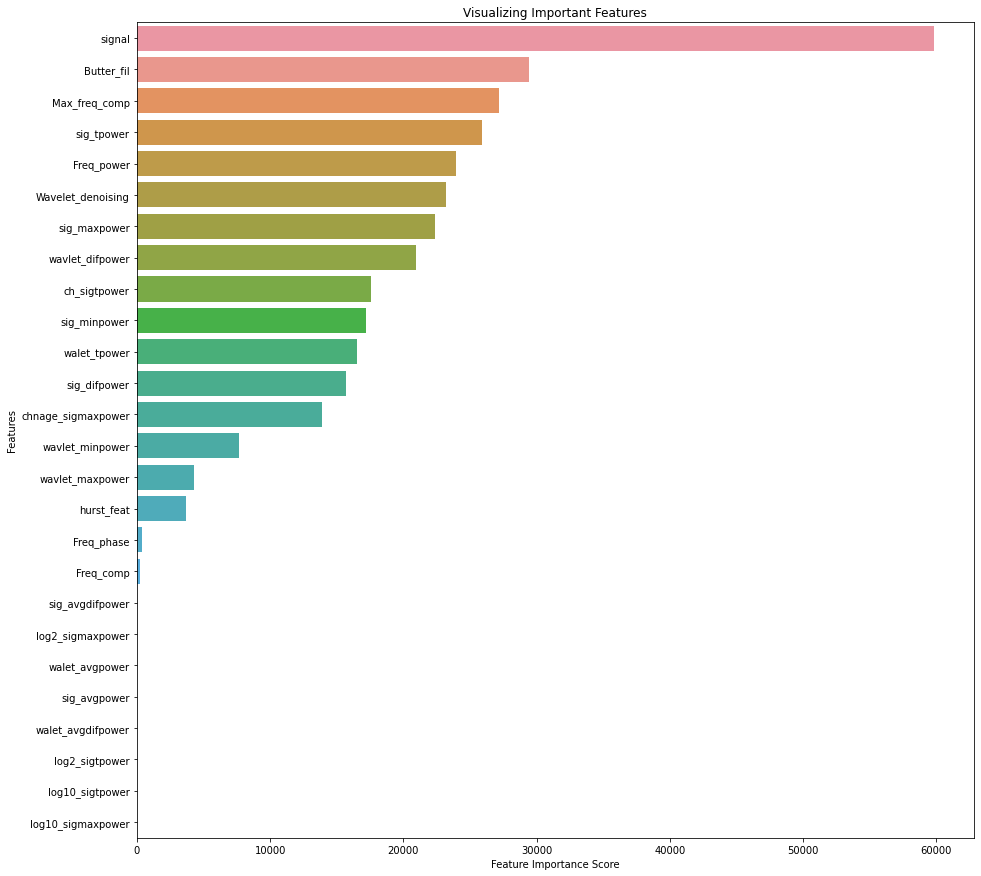

In [ ]:
feature_imp = pd.Series(model.feature_importances_,index=train_data.columns).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

By features importance graph-Signal,Total signal Power,Frequency Power and Maximum power frequency is good features.So we can use this a features to our ML Model

# Hurst Features

Now most of the features are related to particular timestamp.We have to know that is there  any relation with previously occuring data? we do this by Hurst Exponent which tell :<br>


---


<ui>
<li>H>0.5: There is presistent behaviour in data.</li>
<li>H<0.5 :  Mean reverting series,that is any positive movement will followed by a negative movement or vice versa.</li>
<li>H=0.5 : There is no relation with previous timestamp data.</li> 


---






In [ ]:
from hurst import compute_Hc
H, c, data = compute_Hc(train_data['signal'], kind='change', simplified=True)

In [ ]:
print("Hurst_Exponent=",H)
print("C = ",c)

Hurst_Exponent= 0.8760126767280807
C =  7.9720316968549465




---



This show that signal is persistence.That mean signal follow previous time 
stamp for an interval .


---





In [ ]:
def hurst_feature(data):
  """Return Hurst feature """
  H, c, data = compute_Hc(data, kind='change', simplified=True)
  hurst_feat=[]
  prev_time=0
  for ind in range(len(data[0])):
    hurst_feat.extend([data[1][ind]]*(data[0][ind]-prev_time))
    prev_time=data[0][ind]
  return hurst_feat
train_data['hurst_feat']=hurst_feature(train_data['signal'])
test_data['hurst_feat']=hurst_feature(test_data['signal'])


In [ ]:
import pandas as pd
train_data=pd.read_csv('drive/My Drive/train_data.csv')
train_y=train_data.open_channels

test_data=pd.read_csv('drive/My Drive/test_data.csv')

print(train_data.columns)
print(test_data.columns)

Index(['time', 'signal', 'open_channels', 'Freq_comp', 'Butter_fil',
       'Wavelet_denoising', 'Max_freq_comp', 'Freq_phase', 'Freq_power',
       'sig_tpower', 'sig_avgpower', 'sig_maxpower', 'sig_minpower',
       'sig_difpower', 'sig_avgdifpower', 'walet_tpower', 'walet_avgpower',
       'wavlet_maxpower', 'wavlet_minpower', 'wavlet_difpower',
       'walet_avgdifpower', 'hurst_feat'],
      dtype='object')
Index(['time', 'signal', 'Freq_comp', 'Butter_fil', 'Wavelet_denoising',
       'Max_freq_comp', 'Freq_phase', 'Freq_power', 'sig_tpower',
       'sig_avgpower', 'sig_maxpower', 'sig_minpower', 'sig_difpower',
       'sig_avgdifpower', 'walet_tpower', 'walet_avgpower', 'wavlet_maxpower',
       'wavlet_minpower', 'wavlet_difpower', 'walet_avgdifpower',
       'hurst_feat'],
      dtype='object')


In [ ]:
import pandas as pd
train_data=pd.read_csv('drive/My Drive/train_data.csv')
train_y=train_data.open_channels

test_data=pd.read_csv('drive/My Drive/test_data.csv')

print(train_data.columns)
print(test_data.columns)

<h1> Simple Feature Engineering and Finding the best Features 


Use some basic features like shifted signal,moving average mean and try this on different previous denoised signal and power of signal and try to find the best parameter with this feature by train general model and get the feature importance graph and select the best parameter featured .

<h4> 1.Shifted Feature

In [ ]:

def shifted_feature(data_signal,window,signal_type):
  for win in window:
    data_signal[signal_type+"_shif"+str(win)]=data_signal[signal_type].shift(win)
  return data_signal
window=[2,5,8,10,50,75,100,300,700,1000]
train_data=shifted_feature(train_data,window,"signal")
train_data=shifted_feature(train_data,window,"Wavelet_denoising")
test_data=shifted_feature(test_data,window,"signal")
test_data=shifted_feature(test_data,window,"Wavelet_denoising")


<h4> Rolling window 

In [ ]:
def rolling_window(data,window_range,signal_type):
  for win in window_range:
    data[signal_type+"_meanroll"+str(win)]=data[signal_type].rolling(window=win).mean()
    data[signal_type+"_maxroll"+str(win)]=data[signal_type].rolling(window=win).max()
    data[signal_type+"_min_roll"+str(win)]=data[signal_type].rolling(window=win).min()
    
  return data
window=[2,4,6,8,9,10,50,75,100]
train_data=rolling_window(train_data,window,"signal")
train_data=rolling_window(train_data,window,"Wavelet_denoising")
test_data=rolling_window(test_data,window,"signal")
test_data=rolling_window(test_data,window,"Wavelet_denoising")

In [ ]:
import lightgbm as lgb
model = lgb.LGBMClassifier(n_estimators = 1000, class_weight ='balanced')
model.fit(train_data,train_y)
feature_imp = pd.Series(model.feature_importances_,index=train_data.columns).sort_values(ascending=False)

In [ ]:
feature_imp[:53]

signal                        27369
sig_tpower                    17531
sig_maxpower                  12013
Butter_fil                    10366
signal_min_roll2              10318
Max_freq_comp                  9624
signal_shif300                 9341
signal_maxroll2                8664
signal_maxroll100              7922
signal_shif100                 7824
signal_meanroll2               7777
sig_minpower                   7621
Freq_power                     7452
signal_min_roll6               7379
signal_min_roll4               7192
signal_maxroll50               6490
signal_shif75                  6465
signal_maxroll4                6196
signal_shif1000                6168
signal_shif700                 6078
signal_min_roll100             6010
sig_difpower                   5815
wavlet_difpower                5805
signal_maxroll75               5773
signal_shif10                  5697
signal_shif50                  5617
signal_shif2                   5327
signal_min_roll50           

This the top feature with different parameter .We will select some of top features feature 

In [ ]:

feature=['sig_tpower','sig_avgpower','sig_maxpower','sig_minpower','sig_difpower','sig_avgdifpower']
def rolling_window(data,window_range,signal_type):
  for win in window_range:
    data[signal_type+"_meanroll"+str(win)]=data[signal_type].rolling(window=win).mean()
  return data

window=[10,50,100,200,300,500,700,900]
for feat in feature:
  train_data=rolling_window(train_data,window,feat)
  test_data=rolling_window(test_data,window,feat)


In [ ]:

feature=['walet_tpower','walet_avgpower','wavlet_maxpower','wavlet_minpower','wavlet_difpower','walet_avgdifpower']
def rolling_window(data,window_range,signal_type):
  for win in window_range:
    data[signal_type+"_meanroll"+str(win)]=data[signal_type].rolling(window=win).mean()
  return data

window=[50,100,200,300,500,700,850,1000]
for feat in feature:
  train_data=rolling_window(train_data,window,feat)

In [ ]:
import lightgbm as lgb
model = lgb.LGBMClassifier(n_estimators = 1000, class_weight ='balanced',n_jobs=-1)
model.fit(train_data,train_y)
feature_imp = pd.Series(model.feature_importances_,index=train_data.columns).sort_values(ascending=False)

In [ ]:
feature_imp[:50]

signal                          39381
Max_freq_comp                   16621
Butter_fil                      13606
Wavelet_denoising                9817
sig_minpower_meanroll10          7611
sig_difpower_meanroll900         7559
sig_minpower_meanroll900         7207
sig_minpower_meanroll50          6418
sig_difpower_meanroll700         6274
Freq_power                       6197
sig_difpower_meanroll500         6084
sig_tpower_meanroll50            5961
sig_maxpower_meanroll900         5832
sig_maxpower_meanroll100         5827
sig_minpower_meanroll700         5786
sig_difpower_meanroll200         5783
sig_minpower_meanroll500         5716
sig_difpower_meanroll10          5628
sig_maxpower_meanroll50          5496
sig_tpower_meanroll10            5491
sig_difpower_meanroll300         5456
sig_tpower_meanroll900           5426
sig_minpower_meanroll100         5355
sig_difpower_meanroll100         5346
sig_minpower_meanroll300         5344
sig_minpower_meanroll200         5120
sig_difpower

In [ ]:

feature=['sig_tpower','sig_avgpower','sig_maxpower','sig_minpower','sig_difpower','sig_avgdifpower']
def rolling_window(data,window_range,signal_type):
  for win in window_range:
    data[signal_type+"_maxroll"+str(win)]=data[signal_type].rolling(window=win).max()
  return data

window=[10,50,100,500,700]
for feat in feature:
  train_data=rolling_window(train_data,window,feat)
  test_data=rolling_window(test_data,window,feat)


<h4> Exponential Moving Average

In [ ]:
def exp_movingavg(data,window,signal_typ):
  for win in window:
    data[signal_typ+"meanewm"+str(win)]=data[signal_typ].ewm(span=win, adjust=False).mean()
    
  return data
window=[10,30,50,70,100,500,1000]
train_data=exp_movingavg(train_data,window,"signal")
test_data=exp_movingavg(test_data,window,'signal')



In [ ]:
def exp_movingavg(data,window,signal_typ):
  for win in window:
    data[signal_typ+"meanewm"+str(win)]=data[signal_typ].ewm(span=win, adjust=False).mean()
    
  return data
window=[100,500,700,850,900,1000]
train_data=exp_movingavg(train_data,window,"Wavelet_denoising")
test_data=exp_movingavg(test_data,window,"Wavelet_denoising")


del exp_movingavg

In [ ]:
import lightgbm as lgb
model = lgb.LGBMClassifier(n_estimators = 1000, class_weight ='balanced',n_jobs=-1)
model.fit(train_data,train_y)
feature_imp = pd.Series(model.feature_importances_,index=train_data.columns).sort_values(ascending=False)

In [ ]:
feature_imp

signalmeanewm10                 39777
signalmeanewm30                 26722
sig_minpower_maxroll10          17290
sig_maxpower_maxroll10          16022
sig_tpower_maxroll10            15519
signalmeanewm1000               13844
sig_maxpower_maxroll50          13167
sig_difpower_maxroll10          12803
sig_tpower_maxroll50            11755
signalmeanewm50                 10853
sig_minpower_maxroll50          10473
signalmeanewm70                 10280
signalmeanewm100                10036
sig_maxpower_maxroll100          9824
signalmeanewm500                 9408
sig_difpower_maxroll50           9316
sig_tpower_maxroll100            9021
sig_minpower_maxroll700          8336
sig_difpower_maxroll100          7853
sig_minpower_maxroll500          7738
sig_minpower_maxroll100          7636
sig_tpower_maxroll500            7495
sig_difpower_maxroll500          6993
sig_tpower_maxroll700            6824
sig_maxpower_maxroll500          6628
Wavelet_denoisingmeanewm100      6560
sig_maxpower



---



<h4>Weighted Moving Average

In [ ]:

import numpy as np
import pandas as pd

def Hanning(size):
    w = np.hanning(size+2)
    w = np.array(w[1:-1])  # remove zeros at endpoints
    return (w / max(w))

def WeightedMovingAverage(fs, size, pad=True, winType=Hanning, wts=None):
    """Apply a weighted moving average on the supplied series.
    Parameters
    ----------
    s : pandas.Series
        data to be averaged
    size : integer
        how wide a window to use
    pad : Boolean (optional, default = True)
        flag determining whether to pad beginning and end of data with a
        weighted average of the last `size` points. This provides better
        smoothing at the beginning and end of the line, but it tends to have
        zero slope.
    winType : Function (optional, default = Hanning)
        Window function that takes an integer (window size) and returns a list
        of weights to be applied to the data. The default is Hanning, a
        weighted cosine with non-zero endpoints. Other possible windows are:
        * np.bartlett (triangular with endpoints of 0)
        * np.blackman (3 cosines creating taper)
        * np.hamming (weighted cosine)
        * np.hanning (weighted cosine with endpoints of 0)
        * Triangle (triangle with non-zero enpoints, and option to
                    clip top of triangle)
    wts : list (optional, default = None)
        List of weights to use. `size` becomes the length of wts. Use this
        option to provide a custom weighting function. The length of wts
        should be odd, but this is not enforced.
    Returns
    -------
    Pandas Series containing smoothed data
    Notes
    -----
    Defaults to using a Hanning window for weights, centered on
    each point. For points near the beginning or end of data, special
    processing is required that isn't in built-in functions.
    Any rows with no value (nan) are dropped from series, and that reduced
    series is returned. This series will have fewer members than what was
    given, and may cause problems with mismatched indexes.
    """
    def SetLimits(i, hw):
        # i: current data location where window is centred
        # hw: half window width
        ds = max(0, (i-hw))         # data start
        de = min(n-1, (i+hw)) # data end
        ws = hw - (i - ds)          # window start
        we = hw + (de - i)          # window end
        return ds, de, ws, we

    s = fs.dropna()
    if type(wts) == type(None):
        size += (size+1) % 2  # make odd
        window = winType(size)
        window /= window.sum()  # normalize window
    else:
        window = wts / wts.sum()
        size = len(wts)
    n = len(s)
    hw = int(size / 2) # half window width
    # convolve has boundary effects when there is no overlap with the window
    # Begining and end of 'a' must be adjusted to compensate.
    # np.average() effectively scales the weights for the different sizes.
    if pad: # pad the data with reflected values
        # create padded beginning
        y = np.zeros(n+2*hw)
        for i in range(hw):
            y[i] = s.iloc[hw-i]
        for i in range(hw):
            y[i+n+hw] = s.iloc[n-i-1]
        for i in range(n):
            y[i+hw] = s.iloc[i]
        yc = np.convolve(y, window, mode='same')
        a = pd.Series(yc[hw:n+hw],
                      index=s.index,
                      name=s.name)
    else: # clip window as available data decreases
        a = pd.Series(np.convolve(s, window, mode='same'),
                      index=s.index,
                      name=s.name)
        for i in range(hw+1):  # fix the start
            (ds, de, ws, we) = SetLimits(i, hw)
            a.iloc[i] = np.average(s.iloc[ds:de], weights=window[ws:we])
        for i in range(n-hw-1, n):  # fix the end
            (ds, de, ws, we) = SetLimits(i, hw)
            a.iloc[i] = np.average(s.iloc[ds:de], weights=window[ws:we])
    return a

In [ ]:
signal=train_data.signal
Y=train_data.open_channels
data=pd.DataFrame()
data['WemvAv_600']=WeightedMovingAverage(signal,600)
data['WemvAv_300']=WeightedMovingAverage(signal,300)
data['WemvAv_200']=WeightedMovingAverage(signal,200)
data['WemvAv_100']=WeightedMovingAverage(signal,100)
data['WemvAv_50']=WeightedMovingAverage(signal,50)
data['WemAv_sqrt100']=WeightedMovingAverage(np.sqrt(abs(signal)),100)

In [ ]:
import lightgbm as lgb
model = lgb.LGBMClassifier(n_estimators = 1000, class_weight ='balanced',n_jobs=-1)
model.fit(data,Y)
feature_imp = pd.Series(model.feature_importances_,index=data.columns).sort_values(ascending=False)

In [ ]:
feature_imp

WemvAv_50        71443
WemvAv_600       67283
WemAv_sqrt100    59560
WemvAv_100       46366
WemvAv_300       45161
WemvAv_200       40187
dtype: int64

This show the feature importance of weighted moving average with different window and find the best parameter to predict the model.

# Training on Top Features

In [ ]:
def features(data):
  """Return best features selected from the previous analysis"""
  #sigmaxpower=np.log(abs(data['sig_tpower']))/0.0049
  #data['ch_sigtpower']=sigmaxpower
  data["signal_minroll2"]=data['signal'].rolling(window=2).min()
  data["signal_minroll4"]=data['signal'].rolling(window=4).min()
  data["signal_minroll6"]=data['signal'].rolling(window=6).min()
  data["signal_maxroll2"]=data['signal'].rolling(window=2).max()
  data["signal_maxroll100"]=data['signal'].rolling(window=100).max()
  data["signal_maxroll50"]=data['signal'].rolling(window=50).max()
  data["signal_maxroll4"]=data['signal'].rolling(window=4).max()
  data["signal_mmeanroll2"]=data['signal'].rolling(window=2).mean()
  data["signal_shift100"]=data['signal'].shift(100)
  data["signal_shift300"]=data['signal'].shift(300)
  data["signal_shift75"]=data['signal'].shift(75)
  data["signal_shift700"]=data['signal'].shift(700)
  data["signal_shift1000"]=data['signal'].shift(1000)
  data["sig_minpower_meanroll10"]=data['sig_minpower'].rolling(window=10).mean()
  #data["sig_minpower_meanroll50"]=data['sig_minpower'].rolling(window=50).mean()
  data["sig_minpower_meanroll900"]=data['sig_minpower'].rolling(window=900).mean()

  data["sig_difpower_meanroll900"]=data['sig_difpower'].rolling(window=900).mean()
  #data["sig_difpower_meanroll700"]=data['sig_difpower'].rolling(window=700).mean()
  data["sig_tpower_meanroll50"]=data['sig_tpower'].rolling(window=50).mean()
  data["sig_minpower_maxroll10"]=data['sig_minpower'].rolling(window=10).max()
  #data["sig_maxpower_maxroll10"]=data['sig_maxpower'].rolling(window=10).max()
  #data["sig_maxpower_maxroll50"]=data['sig_maxpower'].rolling(window=50).max()
  data["sig_tpower_maxroll10"]=data['sig_tpower'].rolling(window=10).max()
  #data["sig_tpower_maxroll50"]=data['sig_tpower'].rolling(window=50).max()'''


 # data["signalmeanewm1000"]=data['signal'].ewm(span=1000, adjust=False).mean()
  data["signalmeanewm50"]=data['signal'].ewm(span=50, adjust=False).mean()


  data['WemAv_sqrt100']=WeightedMovingAverage(np.sqrt(abs(data['signal'])),100)
  #data['WemvAv_600']=WeightedMovingAverage(data['signal'],600)
  data['WemvAv_50']=WeightedMovingAverage(data['signal'],50)
  data=data.fillna(0)


  data=data.drop(['sig_avgdifpower','walet_avgpower','sig_avgpower','walet_avgdifpower'],axis=1)

  return data

# Train SGD Classifier with hinge loss

In [ ]:
"""Getting the best selected feature for training the model"""
Y=train_data.open_channels
tr_time=train_data.time
train_data=features(train_data)

train_data=train_data.drop(['open_channels','time'],axis=1)
test_t=test_data.time
test_data=test_data.drop(['time'],axis=1)
test_data=features(test_data)


In [ ]:
print(train_data.columns)

Index(['signal', 'Freq_comp', 'Butter_fil', 'Wavelet_denoising',
       'Max_freq_comp', 'Freq_phase', 'Freq_power', 'sig_tpower',
       'sig_maxpower', 'sig_minpower', 'sig_difpower', 'walet_tpower',
       'wavlet_maxpower', 'wavlet_minpower', 'wavlet_difpower', 'hurst_feat',
       'signal_minroll2', 'signal_minroll4', 'signal_minroll6',
       'signal_maxroll2', 'signal_maxroll100', 'signal_maxroll50',
       'signal_maxroll4', 'signal_mmeanroll2', 'signal_shift100',
       'signal_shift300', 'signal_shift75', 'signal_shift700',
       'signal_shift1000', 'sig_minpower_meanroll10',
       'sig_minpower_meanroll900', 'sig_difpower_meanroll900',
       'sig_tpower_meanroll50', 'sig_minpower_maxroll10',
       'sig_tpower_maxroll10', 'signalmeanewm50', 'WemAv_sqrt100',
       'WemvAv_50'],
      dtype='object')


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc
scaler = StandardScaler()
scaled_data =scaler.fit_transform(train_data)

In [ ]:

param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'alpha':list(np.logspace(np.log10(0.000000005), np.log10(0.0005), base = 10, num = 1000)),
              'epsilon':list(np.linspace(0, 1))
              }
model = SGDClassifier(n_jobs=-1)
gs = RandomizedSearchCV(estimator=model, param_distributions=param_grid,cv=3,refit=True,verbose=True,n_jobs = -1)
gs.fit(scaled_data,Y)
print("Best Parameter : ")
print(gs.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 171.1min finished


Best Parameter : 
{'penalty': 'l1', 'epsilon': 0.7346938775510203, 'alpha': 3.0321646977040306e-06}


In [ ]:
model = SGDClassifier(penalty= 'l1', epsilon= 0.7346938775510203, alpha=3.0321646977040306e-06,n_jobs=-1)
model.fit(scaled_data,Y)
pred_y = model.predict(scaled_data)
print("F1_score = {}".format(f1_score(Y,pred_y,average='macro')))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


F1_score = 0.5042125846854718


## Train GBDT

In [ ]:
"""Getting the best selected feature for training the model"""
Y=train_data.open_channels
tr_time=train_data.time
train_data=features(train_data)

train_data=train_data.drop(['open_channels','time'],axis=1)
test_t=test_data.time
test_data=test_data.drop(['time'],axis=1)
test_data=features(test_data)


In [ ]:
print(train_data.columns)

Index(['signal', 'Freq_comp', 'Butter_fil', 'Wavelet_denoising',
       'Max_freq_comp', 'Freq_phase', 'Freq_power', 'sig_tpower',
       'sig_maxpower', 'sig_minpower', 'sig_difpower', 'walet_tpower',
       'wavlet_maxpower', 'wavlet_minpower', 'wavlet_difpower', 'hurst_feat',
       'ch_sigtpower', 'signal_minroll2', 'signal_minroll4', 'signal_minroll6',
       'signal_maxroll2', 'signal_maxroll100', 'signal_maxroll50',
       'signal_maxroll4', 'signal_mmeanroll2', 'signal_shift100',
       'signal_shift300', 'signal_shift75', 'signal_shift700',
       'signal_shift1000', 'sig_minpower_meanroll10',
       'sig_minpower_meanroll50', 'sig_minpower_meanroll900',
       'sig_difpower_meanroll900', 'sig_difpower_meanroll700',
       'sig_tpower_meanroll50', 'sig_minpower_maxroll10',
       'sig_maxpower_maxroll10', 'sig_maxpower_maxroll50',
       'sig_tpower_maxroll10', 'sig_tpower_maxroll50', 'signalmeanewm1000',
       'signalmeanewm50', 'WemAv_sqrt100', 'WemvAv_600', 'WemvAv_50'],
 

## HyperParameter Tuning of GBDT

In [ ]:

param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(50, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(60000, 100000, 10000)),
    'min_child_samples': list(range(200, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.9, 1, 10)),
    'subsample': list(np.linspace(0, 1, 100)),
    'is_unbalance': [True, False]
}
model = lgb.LGBMClassifier()
gs = RandomizedSearchCV(estimator=model, param_distributions=param_grid,cv=3,refit=True,verbose=True)
gs.fit(train_data,Y)
print("Best Parameter : ")
print(gs.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 255.9min finished


Best Parameter : 
{'subsample_for_bin': 70000, 'subsample': 0.14141414141414144, 'reg_lambda': 0.24489795918367346, 'reg_alpha': 0.7551020408163265, 'num_leaves': 101, 'min_child_samples': 480, 'learning_rate': 0.011516814365710655, 'is_unbalance': False, 'colsample_bytree': 0.9333333333333333, 'boosting_type': 'dart'}


In [ ]:
clf=lgb.LGBMClassifier(subsample_for_bin= 70000,subsample=0.14141414141414144,reg_lambda=0.24489795918367346,reg_alpha=0.7551020408163265,\
                       num_leaves=  101,min_child_samples=480,learning_rate= 0.011516814365710655,is_unbalance= False,\
                       colsample_bytree= 0.9333333333333333, boosting_type='dart')
clf.fit(train_data,Y)

LGBMClassifier(boosting_type='dart', class_weight=None,
               colsample_bytree=0.9333333333333333, importance_type='split',
               is_unbalance=False, learning_rate=0.011516814365710655,
               max_depth=-1, min_child_samples=480, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=101,
               objective=None, random_state=None, reg_alpha=0.7551020408163265,
               reg_lambda=0.24489795918367346, silent=True,
               subsample=0.14141414141414144, subsample_for_bin=70000,
               subsample_freq=0)

In [ ]:
train_predict=clf.predict(train_data)

f1_score(Y,train_predict,average='macro')

0.9386360196722813

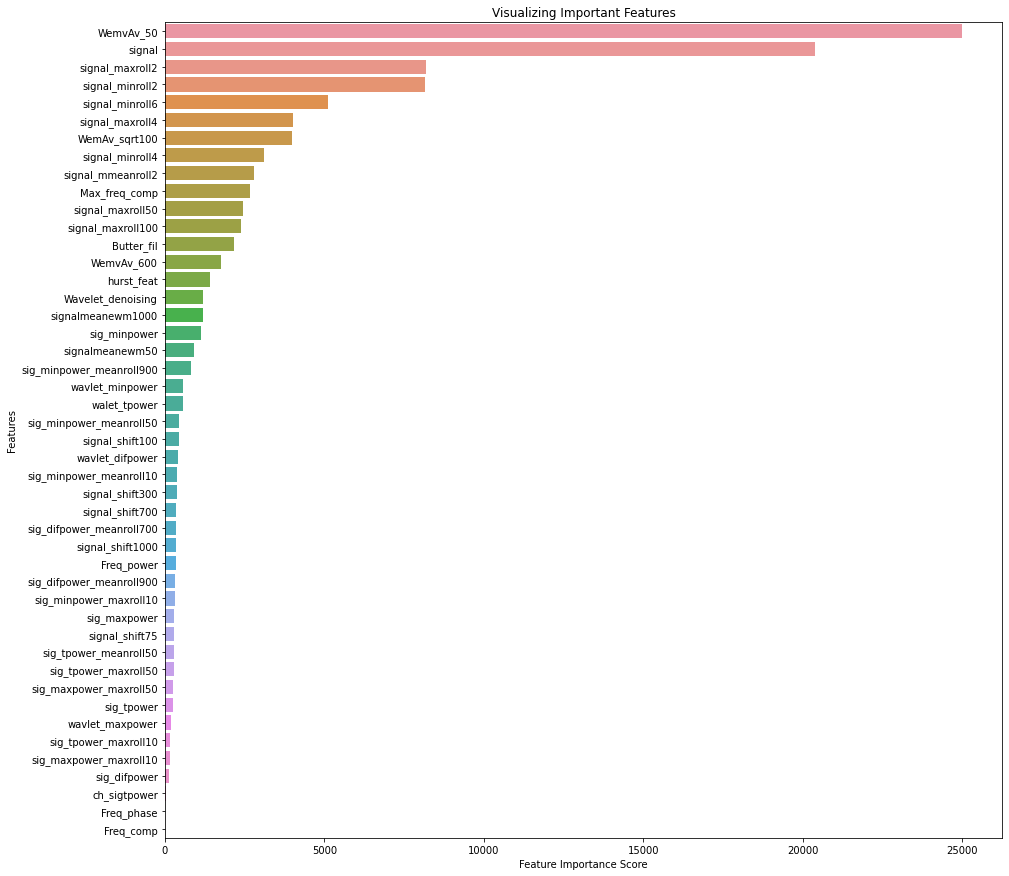

In [ ]:
feature_imp = pd.Series(clf.feature_importances_,index=train_data.columns).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

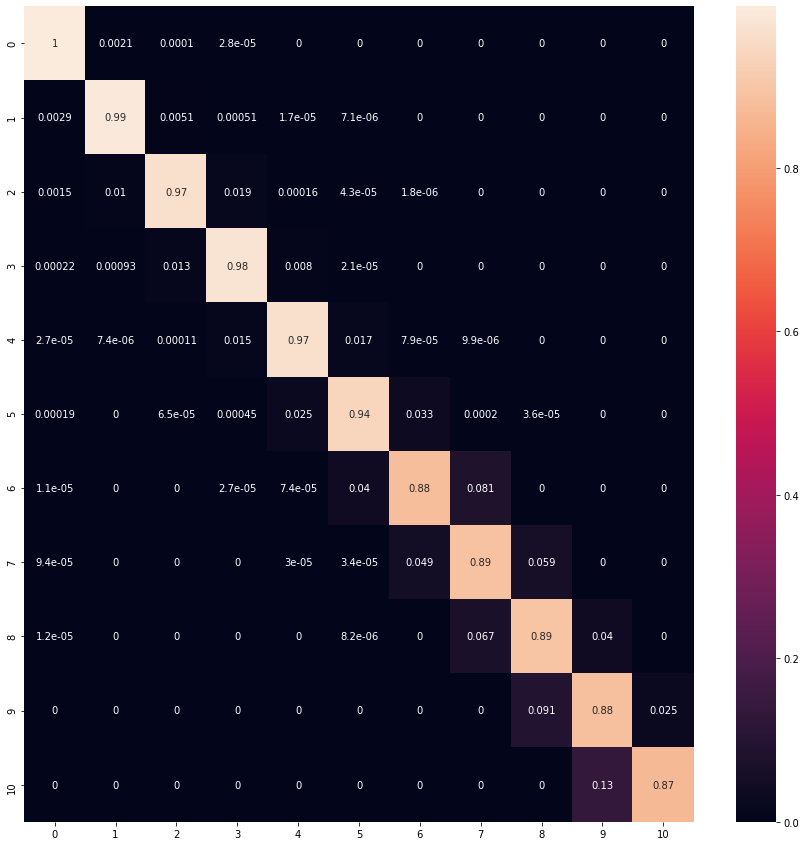

In [ ]:

conf_mat=confusion_matrix(Y,train_predict)
plt.figure(figsize=(15,15))

row_sums = np.round(conf_mat.sum(axis=1),3)
conf_mat = conf_mat / row_sums[:, np.newaxis]
sns.heatmap(conf_mat, annot=True)

Model is good to seperate the channel between 0 to 5 but it is not working good for remain channel to seperate wisely.

In [ ]:
test_pred=clf.predict(test_data)
submission_csv=pd.DataFrame()
submission_csv['time']=test_t
submission_csv['open_channels']=test_pred

In [ ]:
submission_csv.to_csv("submission_csv.csv",index=False,float_format='%.4f')

On test data F1 score is 0.935

# Use RandomForest probability with shifted signal as features 

Train randomforest on shifted features of signal with added features as category which showing that 10 channels are open maximum in some of the batch of signal .This will to predict the model.

In [ ]:
# Idea is taken from https://www.kaggle.com/sggpls/shifted-rfc-pipeline

train = pd.DataFrame()
test = pd.DataFrame()
period = range(-20,20)
for per in period:
  train[f'shifted_period{per}'] = train_data['signal'].shift(periods=per, fill_value=0)
  test[f'shifted_period{per}'] = test_data['signal'].shift(periods=per, fill_value=0)

train['signal']=train_data.signal
test['signal']=test_data.signal

train["category"] = 0
test["category"] = 0

# train segments with more then 9 open channels classes
train.loc[2_000_000:2_500_000-1, 'category'] = 1
train.loc[4_500_000:5_000_000-1, 'category'] = 1

# test segments with more then 9 open channels classes (potentially)
test.loc[500_000:600_000-1, "category"] = 1
test.loc[700_000:800_000-1, "category"] = 1

shifted_RFC = RandomForestClassifier(
            n_estimators=150,
            max_depth=19,
            max_features=10,
            random_state=42,verbose=2
        )
shifted_RFC.fit(train, Y)
np.save("drive/My Drive/Y_train_proba.npy",shifted_RFC.predict_proba(train))
np.save("drive/My Drive/Y_test_proba.npy",shifted_RFC.predict_proba(test))

In [ ]:
y_train_proba = np.load("drive/My Drive/Y_train_proba.npy")
y_test_proba = np.load("drive/My Drive/Y_test_proba.npy")

for i in range(11):
    train_data[f"proba_{i}"] = y_train_proba[:, i]
    test_data[f'proba_{i}'] = y_test_proba[:,i]

##Train SGD with HINGE LOSS

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc
scaler = StandardScaler()
scaled_data =scaler.fit_transform(train_data)

In [ ]:

param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'alpha':list(np.logspace(np.log10(0.000000005), np.log10(0.0005), base = 10, num = 1000)),
              'epsilon':list(np.linspace(0, 1))
              }
model = SGDClassifier(n_jobs=-1)
gs = RandomizedSearchCV(estimator=model, param_distributions=param_grid,cv=3,refit=True,verbose=True)
gs.fit(scaled_data,Y)
print("Best Parameter : ")
print(gs.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 109.6min finished


Best Parameter : 
{'penalty': 'l1', 'epsilon': 0.2857142857142857, 'alpha': 0.00014237195832336237}


In [ ]:
model = SGDClassifier(penalty= 'l1', epsilon= 0.2857142857142857, alpha=0.00014237195832336237,n_jobs=-1)
model.fit(scaled_data,Y)
pred_y = model.predict(scaled_data)
print("F1_score = {}".format(f1_score(Y,pred_y,average='macro')))

F1_score = 0.9305134080559814


## Train GBDT

In [ ]:

param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(50, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(60000, 100000, 10000)),
    'min_child_samples': list(range(200, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.9, 1, 10)),
    'subsample': list(np.linspace(0, 1, 100)),
    'is_unbalance': [True, False]
}
model = lgb.LGBMClassifier()
gs = RandomizedSearchCV(estimator=model, param_distributions=param_grid,cv=3,refit=True,verbose=True)
gs.fit(train_data,Y)
print("Best Parameter : ")
print(gs.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 269.9min finished


Best Parameter : 
{'subsample_for_bin': 90000, 'subsample': 0.7474747474747475, 'reg_lambda': 0.32653061224489793, 'reg_alpha': 0.12244897959183673, 'num_leaves': 147, 'min_child_samples': 470, 'learning_rate': 0.08594195714085727, 'is_unbalance': True, 'colsample_bytree': 0.9777777777777777, 'boosting_type': 'dart'}


In [ ]:
clf=lgb.LGBMClassifier(subsample_for_bin= 90000,subsample=0.7474747474747475,reg_lambda=0.32653061224489793,reg_alpha=0.12244897959183673,\
                       num_leaves=  147,min_child_samples=470,learning_rate= 0.08594195714085727,is_unbalance= True,\
                       colsample_bytree= 0.9777777777777777, boosting_type='dart')
clf.fit(train_data,Y)
train_predict=clf.predict(train_data)
f1_score(Y,train_predict,average='macro')

0.9405222447835161

In [ ]:
test_pred=clf.predict(test_data)
submission_csv=pd.DataFrame()
submission_csv['time']=test_t
submission_csv['open_channels']=test_pred
submission_csv.to_csv("submission_csv.csv",index=False,float_format='%.4f')

<h5> On test data i am getting 0.940

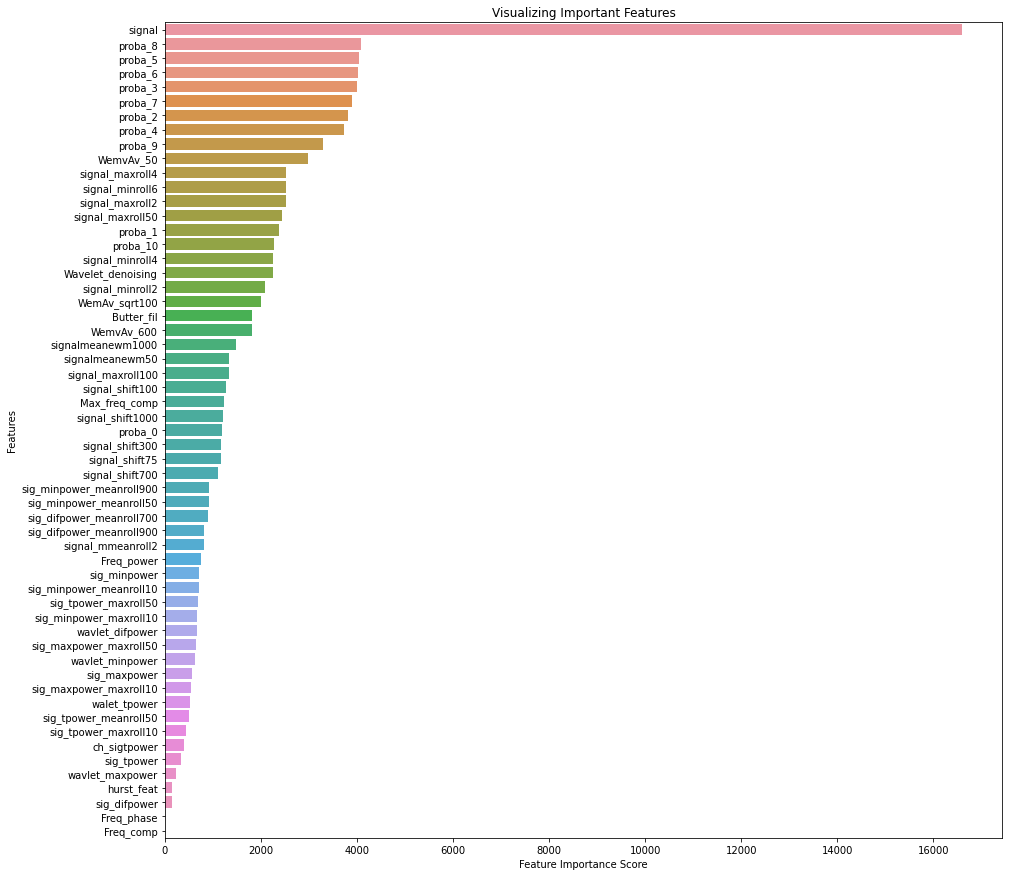

In [ ]:
feature_imp = pd.Series(clf.feature_importances_,index=train_data.columns).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

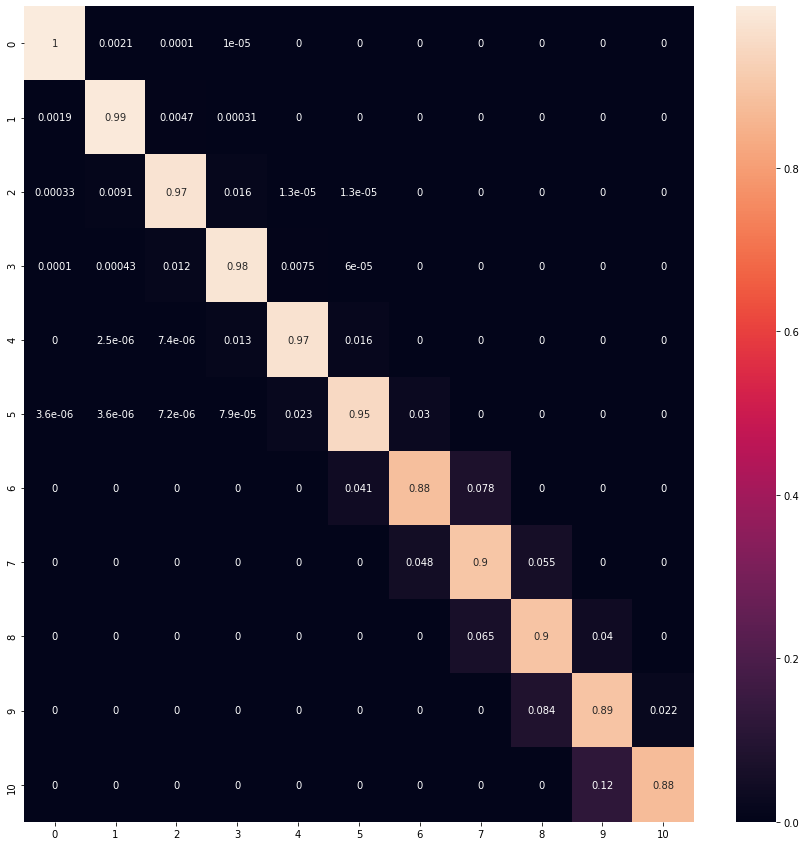

In [ ]:

conf_mat=confusion_matrix(Y,train_predict)
plt.figure(figsize=(15,15))

row_sums = np.round(conf_mat.sum(axis=1),3)
conf_mat = conf_mat / row_sums[:, np.newaxis]
sns.heatmap(conf_mat, annot=True)

This model working good to seperate the channel easily than the previous model.Stil the channel 9 ,6and 10 are not good to predicatable.

# STACKING

Step to follow:
<ul>
<li> Divide the data into train and test split.
<li> Divide the train data into 50-50 d1 and d2 dataset.
<li> Train k model with k sample taken from d1 with replacement.
<li> Convert d2 dataset feature into k feature from k trained model prediction.
<li>Train d2 dataset of k feature with meta classifier.


### Train on 242 GBDT classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")


In [ ]:
train_data.columns

Index(['signal', 'Freq_comp', 'Butter_fil', 'Wavelet_denoising',
       'Max_freq_comp', 'Freq_phase', 'Freq_power', 'sig_tpower',
       'sig_maxpower', 'sig_minpower', 'sig_difpower', 'walet_tpower',
       'wavlet_maxpower', 'wavlet_minpower', 'wavlet_difpower', 'hurst_feat',
       'signal_minroll2', 'signal_minroll4', 'signal_minroll6',
       'signal_maxroll2', 'signal_maxroll100', 'signal_maxroll50',
       'signal_maxroll4', 'signal_mmeanroll2', 'signal_shift100',
       'signal_shift300', 'signal_shift75', 'signal_shift700',
       'signal_shift1000', 'sig_minpower_meanroll10',
       'sig_minpower_meanroll900', 'sig_difpower_meanroll900',
       'sig_tpower_meanroll50', 'sig_minpower_maxroll10',
       'sig_tpower_maxroll10', 'signalmeanewm50', 'WemAv_sqrt100', 'WemvAv_50',
       'proba_0', 'proba_1', 'proba_2', 'proba_3', 'proba_4', 'proba_5',
       'proba_6', 'proba_7', 'proba_8', 'proba_9', 'proba_10'],
      dtype='object')

In [ ]:
class StackingwithmetaClassifier():
  def __init__(self,classifiers):
    self.n_classifers = len(classifiers)
    self.classifiers = classifiers
    self.k_train_model = []
    self.meta_clf = None
  def fit(self,d1_train):

    for fold,clf in enumerate(self.classifiers):
      data = d1_train[d1_train['fold']==fold]
      label = data['Class']
      data = data.drop(['Class','fold'],axis=1)
      clf.fit(data,label)
      self.k_train_model.append(clf)
    return self.k_train_model
  
  def get_feature(self,data):
    new_dataset = np.empty((data.shape[0],len(self.k_train_model)),)
    for k_feat,clf in enumerate(self.k_train_model):
      new_dataset[:,k_feat] = clf.predict(data)
    return new_dataset

n_clf = []
for _ in range(242):
  n_clf.append(lgb.LGBMClassifier())


X_train,X_test,Y_train,Y_test = train_test_split(train_data, Y, test_size=0.20, random_state=42)
d1_train,d2_train,d1_Y,d2_Y = train_test_split(X_train,Y_train, test_size=0.5, random_state=42)


d1_train['Class'] = d1_Y
gf = GroupKFold(n_splits=len(n_clf))

d1_train.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(gf.split(X=d1_train.index, y=d1_Y, groups=d1_train.index//100)):
    d1_train.loc[d1_train.iloc[val_index].index, 'fold'] = fold_number


stacked_clf = StackingwithmetaClassifier(n_clf)
k_model = stacked_clf.fit(d1_train)

new_dataset = stacked_clf.get_feature(d2_train)
new_dataset.shape

(2000000, 242)

In [ ]:

param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(50, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(60000, 100000, 10000)),
    'min_child_samples': list(range(200, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.9, 1, 10)),
    'subsample': list(np.linspace(0, 1, 100)),
    'is_unbalance': [True, False]
}
model = lgb.LGBMClassifier()
gs = RandomizedSearchCV(estimator=model, param_distributions=param_grid,cv=3,refit=True,verbose=True)
gs.fit(new_dataset,d2_Y)
print("Best Parameter : ")
print(gs.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 385.3min finished


Best Parameter : 
{'subsample_for_bin': 80000, 'subsample': 0.19191919191919193, 'reg_lambda': 0.5714285714285714, 'reg_alpha': 0.4693877551020408, 'num_leaves': 100, 'min_child_samples': 235, 'learning_rate': 0.0432421163786586, 'is_unbalance': True, 'colsample_bytree': 0.9666666666666667, 'boosting_type': 'dart'}


In [ ]:
clf=lgb.LGBMClassifier(subsample_for_bin=  80000,subsample=0.19191919191919193,reg_lambda=0.5714285714285714,reg_alpha=0.4693877551020408,\
                       num_leaves=  100,min_child_samples=235,learning_rate= 0.0432421163786586,is_unbalance=  True,\
                       colsample_bytree= 0.9666666666666667, boosting_type='dart')
clf.fit(new_dataset,d2_Y)


LGBMClassifier(boosting_type='dart', class_weight=None,
               colsample_bytree=0.9666666666666667, importance_type='split',
               is_unbalance=True, learning_rate=0.0432421163786586,
               max_depth=-1, min_child_samples=235, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=100,
               objective=None, random_state=None, reg_alpha=0.4693877551020408,
               reg_lambda=0.5714285714285714, silent=True,
               subsample=0.19191919191919193, subsample_for_bin=80000,
               subsample_freq=0)

In [ ]:
new_test_data = stacked_clf.get_feature(X_test)
new_test_data.shape

(1000000, 242)

In [ ]:
train_predict=clf.predict(new_test_data)
f1_score(Y_test,train_predict,average='macro')

0.9381295652428462

### Train on 128 Randomforest classifier

In [ ]:
class StackingwithmetaClassifier():
  def __init__(self,classifiers):
    self.n_classifers = len(classifiers)
    self.classifiers = classifiers
    self.k_train_model = []
    self.meta_clf = None
  def fit(self,d1_train):

    for fold,clf in enumerate(self.classifiers):
      data = d1_train[d1_train['fold']==fold]
      label = data['Class']
      data = data.drop(['Class','fold'],axis=1)
      clf.fit(data,label)
      self.k_train_model.append(clf)
    return self.k_train_model
  
  def get_feature(self,data):
    new_dataset = np.empty((data.shape[0],len(self.k_train_model)),)
    for k_feat,clf in enumerate(self.k_train_model):
      new_dataset[:,k_feat] = clf.predict(data)
    return new_dataset

n_clf = []
for _ in range(128):
  n_clf.append(RandomForestClassifier())


X_train,X_test,Y_train,Y_test = train_test_split(train_data, Y, test_size=0.20, random_state=42)
d1_train,d2_train,d1_Y,d2_Y = train_test_split(X_train,Y_train, test_size=0.5, random_state=42)


d1_train['Class'] = d1_Y
gf = GroupKFold(n_splits=len(n_clf))

d1_train.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(gf.split(X=d1_train.index, y=d1_Y, groups=d1_train.index//100)):
    d1_train.loc[d1_train.iloc[val_index].index, 'fold'] = fold_number


stacked_clf = StackingwithmetaClassifier(n_clf)
k_model = stacked_clf.fit(d1_train)

new_dataset = stacked_clf.get_feature(d2_train)
new_dataset.shape

(2000000, 128)

In [ ]:
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(50, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(60000, 100000, 10000)),
    'min_child_samples': list(range(200, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.9, 1, 10)),
    'subsample': list(np.linspace(0, 1, 100)),
    'is_unbalance': [True, False]
}

model = lgb.LGBMClassifier()
gs = RandomizedSearchCV(estimator=model, param_distributions=param_grid,cv=3,refit=True,verbose=True)
gs.fit(new_dataset,d2_Y)
print("Best Parameter : ")
print(gs.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 167.1min finished


Best Parameter : 
{'subsample_for_bin': 90000, 'subsample': 0.30303030303030304, 'reg_lambda': 0.6938775510204082, 'reg_alpha': 0.6326530612244897, 'num_leaves': 139, 'min_child_samples': 340, 'learning_rate': 0.009402520275642907, 'is_unbalance': True, 'colsample_bytree': 0.9, 'boosting_type': 'gbdt'}


In [ ]:
clf=lgb.LGBMClassifier(subsample_for_bin= 90000,subsample=0.30303030303030304,reg_lambda=0.6938775510204082,reg_alpha=0.6326530612244897,\
                       num_leaves=  139,min_child_samples=340,learning_rate= 0.009402520275642907,is_unbalance= True,\
                       colsample_bytree= 0.9, boosting_type='gbdt')
clf.fit(new_dataset,d2_Y)
new_test_data = stacked_clf.get_feature(X_test)
train_predict=clf.predict(new_test_data)
f1_score(Y_test,train_predict,average='macro')

0.9381898324506929

# Compare Result.

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Mode","Score on Train ","Score on Test"]

x.add_row(["ML MODEL 1", 0.938,0.935])
x.add_row(["ML MODEL 2", 0.940,0.940])

print(x)


+------------+-----------------+---------------+
|    Mode    | Score on Train  | Score on Test |
+------------+-----------------+---------------+
| ML MODEL 1 |      0.938      |     0.935     |
| ML MODEL 2 |       0.94      |      0.94     |
+------------+-----------------+---------------+


In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Stacking ",'K Model',"Score"]

x.add_row(["GBDT", 242,0.9381])
x.add_row(["Randomforest", 128,0.9381])

print(x)


+--------------+---------+--------+
|  Stacking    | K Model | Score  |
+--------------+---------+--------+
|     GBDT     |   242   | 0.9381 |
| Randomforest |   128   | 0.9381 |
+--------------+---------+--------+


# DEEP LEARNING MODEL

In [ ]:
#Requirements
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_addons as tfa
import gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold,GroupKFold

from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import losses, models, optimizers
import datetime
import random

In [ ]:
import pandas as pd
train_data=pd.read_csv('drive/My Drive/train_data.csv')
train_y=train_data.open_channels

test_data=pd.read_csv('drive/My Drive/test_data.csv')



In [ ]:
y_train_proba = np.load("drive/My Drive/Y_train_proba.npy")
y_test_proba = np.load("drive/My Drive/Y_test_proba.npy")

for i in range(11):
    train_data[f"proba_{i}"] = y_train_proba[:, i]
    test_data[f'proba_{i}'] = y_test_proba[:,i]

## **Stadardization** THE SIGNAL

In [ ]:
#standardization 
mean = train_data.signal.mean()
sigma = train_data.signal.std()
train_data['signal'] = (train_data.signal - mean) / sigma
test_data['signal'] = (test_data.signal - mean) / sigma

# Batching the Signal 

In [ ]:
def batching(df, batch_size):
  df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
  df['group'] = df['group'].astype(np.uint16)
  return df
train_data = batching(train_data,4000)
test_data = batching(test_data,4000)

# Featurization of Signal 

In [ ]:
def featurization(df, windows):
  for window in windows:    
      df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
      df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
  df['signal_2'] = df['signal']**2
  return df
train_data = featurization(train_data, windows =[1,2,3])
test_data = featurization(test_data, windows = [1,2,3])

# Define the Model Architecture- WaveNet



In [ ]:

def Classifier(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = tf.keras.layers.Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same",kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = tf.keras.layers.Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = tf.keras.layers.Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = tf.keras.layers.Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = tf.keras.layers.Multiply()([tanh_out, sigm_out])
            x = tf.keras.layers.Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = tf.keras.layers.Add()([res_x, x])
        return res_x
    
    inp = tf.keras.layers.Input(shape = (shape_))
    x = cbr(inp, 64, 7, 1, 1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = wave_block(x, 16, 3, 12)
    x = tf.keras.layers.BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = tf.keras.layers.BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = cbr(x, 32, 7, 1, 1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = wave_block(x, 64, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = tf.keras.models.Model(inputs = inp, outputs = out)
    
    opt = tf.keras.optimizers.Adam(lr = 0.015)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer = opt, metrics = 'accuracy')
    return model



In [ ]:
features = ['signal','proba_0', 'proba_1', 'proba_2',
       'proba_3', 'proba_4', 'proba_5', 'proba_6', 'proba_7', 'proba_8',
       'proba_9', 'proba_10', 'signal_shift_pos_1',
       'signal_shift_neg_1', 'signal_shift_pos_2', 'signal_shift_neg_2',
       'signal_shift_pos_3', 'signal_shift_neg_3', 'signal_2']


# K Fold training Loop 


In [ ]:
preds_ = np.zeros((2000000, 11))
oof_   = np.zeros((len(train_data),11))

gf = GroupKFold(n_splits=5)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, verbose=0, mode='auto',
    min_delta=0.01, cooldown=1, min_lr=0)


class MyCustomCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

test_data = np.array(list(test_data.groupby('group').apply(lambda x: x[features].values)))
print("Test_Data = ",test_data.shape)

target_cols = ['target_'+str(i) for i in range(11)]
train_target = tf.keras.utils.to_categorical(train_data['open_channels'])
train_tr = pd.DataFrame(train_target,columns = target_cols)
train_tr['group'] = train_data['group']


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



for fold_number, (train_index, val_index) in enumerate(gf.split(train_data, train_data['open_channels'], train_data['group'])):
  train_x = np.array(list(train_data.iloc[train_index].groupby('group').apply(lambda x: x[features].values)))
  valid_x = np.array(list(train_data.iloc[val_index].groupby('group').apply(lambda x: x[features].values)))
  train_y = np.array(list(train_tr.iloc[train_index].groupby('group').apply(lambda x: x[target_cols].values)))
  valid_y = np.array(list(train_tr.iloc[val_index].groupby('group').apply(lambda x: x[target_cols].values)))
  print('Training Data shape = ',train_x.shape)
  print('Valid Data shape = ',valid_x.shape)
  print('Training Target shape = ',train_y.shape)
  print('Valid Target shape = ',valid_y.shape)
  train_gen = 
  gc.collect()
  shape_ = (None, train_x.shape[2])
  model = Classifier(shape_)
  model.fit(train_x,train_y,batch_size = 16,epochs = 100, validation_data = (valid_x,valid_y)
                  ,callbacks = [lr_reducer,tensorboard_callback,MyCustomCallback()])
  
  preds_f = model.predict(valid_x)
  f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  np.argmax(preds_f, axis=2).reshape(-1), average = 'macro') # need to get the class with the biggest probability
  print(f'Training fold {fold_number + 1} completed. macro f1 score : {f1_score_ :1.5f}')
  preds_f = preds_f.reshape(-1, preds_f.shape[-1])
  oof_[val_index,:] += preds_f/5
  te_preds = model.predict(test_data)
  te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
  preds_ += te_preds / 5



Test_Data =  (500, 4000, 19)
Training Data shape =  (1000, 4000, 19)
Valid Data shape =  (250, 4000, 19)
Training Target shape =  (1000, 4000, 11)
Valid Target shape =  (250, 4000, 11)
Epoch 1/100
63/63 [==============================] - 16s 256ms/step - loss: 1.2779 - accuracy: 0.5432 - val_loss: 9.5520 - val_accuracy: 0.1033 - lr: 0.0150
Epoch 2/100
63/63 [==============================] - 10s 157ms/step - loss: 0.8153 - accuracy: 0.6847 - val_loss: 1.5118 - val_accuracy: 0.5090 - lr: 0.0150
Epoch 3/100
63/63 [==============================] - 10s 158ms/step - loss: 0.7039 - accuracy: 0.7241 - val_loss: 0.8710 - val_accuracy: 0.6489 - lr: 0.0150
Epoch 4/100
63/63 [==============================] - 10s 158ms/step - loss: 0.6076 - accuracy: 0.7623 - val_loss: 0.5548 - val_accuracy: 0.7934 - lr: 0.0150
Epoch 5/100
63/63 [==============================] - 10s 159ms/step - loss: 0.5687 - accuracy: 0.7876 - val_loss: 4.4221 - val_accuracy: 0.4581 - lr: 0.0150
Epoch 6/100
63/63 [===========

In [ ]:
f1_score_ = f1_score(np.argmax(oof_,axis=1).reshape(-1), np.array(train_data['open_channels']).reshape(-1), average = 'macro')
f1_score_

0.9366776142249708

# SUMMARY:


1.   Initially,try to visualize the signal.
2.   Remove added drift from the signal with help of curve fitting technique.
3.  Try to remove noise from the signal with different technique like Fourier transform,Butterworth filter,Wavelet denoising.
4. Explorartary Data analysis is perform on the data and also analysis the denoised signal.
5. Feature engineering is perform on signal .Try different feature like maximum frequency power compoent,TimeFrequency analysis used as feature.Some general feature like Moving average,Weighted Moving average etc and find the best parameter for that feature.
6. Train the xgboost model on the best selected feature.
7. Train different model with probility that was taken from randomforest model which was train on only shifted signal as feature and category feature that give privilged to the more misclassified channel by previous model.
8. Compare the result on both the model.
9. Initialize the Deep learning requirement and some featurization.
10. Define the wavenet architecture.
11. Train the model with k fold training loop.


